# Applying deDANSy to uncover the coordinated changes and key molecular effectors of SOX10-deficient cells.

Here, we use deDANSy to describe a functional coordination of proteins and how distinct language subnetworks are between up and down regulated genes. For this analysis, we also compare this to GSEA results to show how deDANSy both expands these results and limits bias from using domains rather than incomplete gene set annotations to find overlooked effectors of phenotypes. We show how two perturbations, which results in SOX10-deficiency, achieve this through different means.

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy.stats as stats
import json
import gseapy as gp
from pybiomart import Dataset
import generateCompleteProteome
import ngramNets
import random
import ngramUtilities
from collections import Counter
import networkx as nx
import upsetplot
import matplotlib.lines as lines
import scipy.cluster.hierarchy as hierarchy

from enrichment_plotting_helpers import *

In [2]:
# Creating some default parameters for the matplotlib plots.
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01
plt.rcParams['legend.edgecolor'] = 'k'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['axes.axisbelow'] = True

In [3]:
complete_ref,_ = generateCompleteProteome.import_proteome_files()

# Network drawing aesthetic parameters which will be used for consistency across network graphs.
net_draw_params = {'node_size':1, 'edgecolors':'k',
        'edge_color':'#808080', 'width':0.1, 'linewidths':0.2}
# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://useast.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id','external_gene_name','external_synonym','uniprotswissprot'])

In [4]:
# Defining helper functions to gather the results and plot them.
def get_plotting_data(res,metric):
    '''
    Gets the data that will be plotted in the bubble plot. Acceptable metrics are NS or IQR only.

    Parameters:
    -----------
        res: pandas DataFrame
            The imported data from running the enrichment analysis using the enrichment script.
        metric: str
            Which metric to retrieve.

    Returns:
    --------
        plot_data: pandas DataFrame
            The data that will be used for the plot
    '''
    if metric in['NS', 'IQR']:
        cat_map = {True:0, False:1}
    else:
        raise ValueError('Improper metric requested.')

    # Putting the data into the proper format
    plot_data = res[res['Metric'] == metric].drop("Metric", axis = 1)
    plot_data = plot_data.pivot(index = 'Comparison',columns = ['variable'])
    plot_data = plot_data['value'].reset_index()
    plot_data.columns.name = None

    # Adding in a few new variables related to the plot
    plot_data['FPR_Binary'] = plot_data[metric+'_FPR'] <= 0.05
    plot_data['Sign'] = plot_data[metric+' Cohen'] > 0
    plot_data['Score'] = np.abs(plot_data[metric+' Cohen'])
    plot_data['Category'] = plot_data['Sign'].map(cat_map)
    
    # Adding in some dummy variables to force some consistent sizes
    if metric == 'NS':
        for i in range(6):
            plot_data.loc[i+len(plot_data)] = None
            plot_data.loc[i+len(plot_data), 'Score'] = i
    else:
        # The IQR scores tend to be between 0-2 so getting the closest integer and then taking 5 steps to force the size
        max_vals = np.ceil(plot_data['Score'].max()) 
        for i,v in enumerate(np.linspace(0,max_vals,5)):
            plot_data.loc[i+len(plot_data)] = None
            plot_data.loc[i+len(plot_data), 'Score'] = v

    return plot_data


def plot_functional_scores(res, show_FPR_handle=True, aspect = 0.9):
     
    # Setting up the data and base plot
    data_plot = get_plotting_data(res, 'NS')
    _, axs = plt.subplots(1,2,figsize = (3,1.5))
    plt.subplot(1,2,1)
    sns.scatterplot(data_plot, y = 'Comparison', size='Score', x = 'Category',
    hue='FPR_Binary',sizes = (1,50), size_norm = (0,5),
                    palette=['mediumorchid', 'silver'],hue_order=[True, False],
                    linewidth = 0.5,edgecolor='k')
    plt.gca().set_aspect(aspect)

    # Adding in labels
    plt.title('Separation Relative\nto Random Genes',fontdict={'size':5})
    plt.xlabel(None)

    # Ensuring both ticks are present even if one of the categories is missing.
    plt.xticks([0,1],['More', 'Less'], rotation=45, ha='right')
    plt.xlim(-0.5,1.5)
    
    # Cleaning up the legend slightly
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles, new_labels = clean_up_legend(handles, labels, show_FPR_handle)
    l = plt.legend(new_handles,new_labels,bbox_to_anchor=(1,1), edgecolor='k', handletextpad=0.1)
    l.get_frame().set_linewidth(0.5)
    for h in l.legend_handles:
        if not isinstance(h, lines.Line2D):
            h.set_edgecolor('k')
            h.set_linewidth(.5)
        
    # When there are several comparisons it is a little easier to digest when there are grid lines
    if len(set(data_plot['Comparison'].tolist())) >= 3:
        plt.grid(visible=True,axis='y', linewidth =0.25, linestyle= ':')

    # Now the IQR version
    data_plot = get_plotting_data(res, 'IQR')
    plt.subplot(1,2,2)
    sns.scatterplot(data_plot, y = 'Comparison', size='Score', x = 'Category',
    hue='FPR_Binary',sizes = (1,50),
                    palette=['seagreen', 'silver'],hue_order=[True, False],
                    linewidth = 0.5,edgecolor='k', legend='brief')
    
    plt.xticks([0,1],['Stably Distinct', 'Unstable/Overlap'], rotation=45, ha='right')
    plt.xlabel(None)
    plt.title('Enriched \nn-gram neighborhoods',fontdict={'size':5})
    plt.xlim([-0.5,1.5])
    plt.gca().set_aspect(aspect)
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles, new_labels = clean_up_legend(handles, labels, show_FPR_handle)
    l = plt.legend(new_handles,new_labels,bbox_to_anchor=(1,1), edgecolor='k', handletextpad=0.1)
    l.get_frame().set_linewidth(0.5)
    # Removing specific handles since they add more than necessary
    for h in l.legend_handles:
        if not isinstance(h, lines.Line2D):
            h.set_edgecolor('k')
            h.set_linewidth(.5)
            
    plt.ylabel(None)
    plt.tick_params('y',labelleft=None)
    
    if len(set(data_plot['Comparison'].tolist())) >=3:
        plt.grid(visible=True,axis='y', linewidth =0.25, linestyle= ':')
        
    return axs

def clean_up_legend(handles, labels, show_FPR = True):
    
    if show_FPR:
            handles_2_rm = [5,7,9]
    else:
        handles_2_rm = [0,1,2,5,7,9] #Will not always need the FPR legend details so will remove them as well
    
    new_h = [h for i,h in enumerate(handles) if i not in handles_2_rm]
    new_l = [h for i,h in enumerate(labels) if i not in handles_2_rm]
    
    if show_FPR:
        new_l[0] = 'FPR$\leq$0.05'
        new_h.insert(3,new_h[3])
        new_l.insert(3,'')
    
    return new_h, new_l

def format_results(dataset_results):
    
    variables_2_keep = ['NS Cohen', 'IQR Cohen', 'NS p_log', 'IQR p_log', 'NS_FPR', 'IQR_FPR']
    res = dataset_results[dataset_results['variable'].isin(variables_2_keep)].copy()
    res['Metric'] = res['variable'].str.split(' ').str[0]
    res['Metric'] = res['Metric'].str.split('_').str[0]

    return res
    

In [5]:
# Hallmark Gene sets for GSEA
hallmarks = pd.read_json('h.all.v2024.1.Hs.json')
hallmarks = hallmarks.to_dict()

# Retrieving all the gene names and converting to UniProt IDs as necessary
hallmark_ids = set()
hall_conv = {}
hall_gs = {}
for gs in hallmarks:
    genes = hallmarks[gs]['geneSymbols']
    hall_gs[gs] = genes
    ids = set(gene_ID_conv[gene_ID_conv['Gene name'].isin(genes) | gene_ID_conv['Gene Synonym'].isin(genes)]['UniProtKB/Swiss-Prot ID'])
    ids = [x for x in ids if str(x) != 'nan']
    hall_conv[gs] = ids
    hallmark_ids.update(ids)

## Standard differential gene expression analysis

Here, we define DEGs using the same cutoffs we develop for the deDANSy results (log2 Fold-Change > 3 and p-adjusted value < 0.001) across the CRISPR-mediated knockdown of SOX10 or an in vivo selection of BRAFi and MEKi tolerant cells (CRT), which have downregulated SOX10 expression.

In [6]:
# For reproducibility
random.seed(882)

# Getting the dataset of interest and performing GSEA with the Hallmarks gene sets
filename = 'DEG_data/Sox10_Invasion_DEG_Results.csv'
data = pd.read_csv(filename)
data.dropna(subset=['external_gene_name'], axis = 0,inplace=True)
# Now getting just the interesting data as inputs for the gsea analysis
comparison_OI = '4-11_v_A375'
deg_labels = list(comparison_OI.split('_v_'))
compsOI = ['4-11_v_A375','CRT34_v_A375','CRT34_v_4-11', '2-18_v_A375','CRT35_v_A375', '4-11_v_2-18','CRT35_v_CRT34']
full_gsea_res = {}
for comp in compsOI:
    gsea_dataOI = data.filter(['external_gene_name','log2FoldChange_'+comp, 'padj_'+comp,'stat_'+comp])
    gsea_dataOI['rank'] =  gsea_dataOI['stat_'+comp]#-np.sign(gsea_dataOI['log2FoldChange_'+comparison_OI])*np.log10(gsea_dataOI['padj_'+comparison_OI])
    gsea_dataOI.sort_values('rank',ascending=True, inplace=True)
    gsea_dataOI = gsea_dataOI.filter(['external_gene_name', 'rank']).drop_duplicates() # Dropping duplicates due to some ensembl IDs mapping to the same gene since they are not restricted to only the primary assembly.
    gsea_res = gp.prerank(rnk=gsea_dataOI, gene_sets=hall_gs,min_size=15, max_size=500, outdir=None, verbose=True, threads=4)
    full_gsea_res[comp] = gsea_res.res2d.copy()

2025-07-01 15:50:21,908 [INFO] Input gene rankings contains duplicated IDs
2025-07-01 15:50:21,912 [WARNING] Duplicated values found in preranked stats: 1.90% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-01 15:50:21,912 [INFO] Parsing data files for GSEA.............................
2025-07-01 15:50:21,928 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=15
2025-07-01 15:50:21,929 [INFO] 0050 gene_sets used for further statistical testing.....
2025-07-01 15:50:21,929 [INFO] Start to run GSEA...Might take a while..................
2025-07-01 15:50:23,278 [INFO] Congratulations. GSEApy runs successfully................

2025-07-01 15:50:23,315 [INFO] Input gene rankings contains duplicated IDs
2025-07-01 15:50:23,320 [WARNING] Duplicated values found in preranked stats: 1.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-01 15:50:23,320 [INFO] Parsing data

In [7]:
# Going through and grabbing the enriched genesets (up-regulated only to start) relative to the control
condsOI = ['2-18_v_A375','4-11_v_A375','CRT34_v_A375','CRT35_v_A375']
subtype_mapping = {'4-11_v_A375':'gSOX10 #4','CRT34_v_A375':'CRT34', '2-18_v_A375':'gSOX10 #2','CRT35_v_A375':'CRT35'}
comp_sets = {}
comp_sets_full = {}
for cond in condsOI:
    gsea_res_temp = full_gsea_res[cond]
    enriched = gsea_res_temp[(gsea_res_temp['NES'] >0) & (gsea_res_temp['FDR q-val'] <= 0.05)]['Term'].tolist()
    subtype = subtype_mapping[cond]
    comp_sets[subtype] = enriched
    comp_sets_full[subtype] = gsea_res_temp[gsea_res_temp['FDR q-val'] <= 0.05]['Term'].tolist()

In [8]:

gsea_upset = upsetplot.from_contents(comp_sets)
gsea_upset_expanded = upsetplot.UpSet(gsea_upset, subset_size='count',facecolor = 'darkorange', totals_plot_elements=0, element_size=10,include_empty_subsets=True,sort_categories_by='input')

gsea_upset.index.set_names(['gRNA_SOX10 #2','A','B', 'CRT35'], inplace=True) # Renaming here just for removing the names afterwards in the final figure.

/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

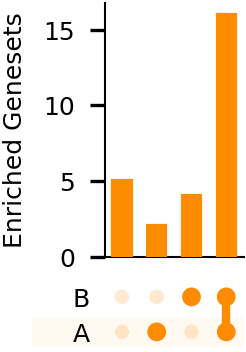

In [9]:
gsea_upset_expanded_small = upsetplot.UpSet(gsea_upset.droplevel(level=['gRNA_SOX10 #2','CRT35']), subset_size='count',facecolor = 'darkorange', totals_plot_elements=0, element_size=10,sort_categories_by='input')
gsea_upset_expanded_small.plot()
plt.ylabel('Enriched Genesets')
plt.gcf().set_size_inches(0.91,1.5)

# All below is for aesthetics to unify with my plots (will be adding the edgecolors after manually)
ax = plt.gca()
ax.grid(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(0.5)
#plt.savefig('Figures/Manuscript Figures/Figure deDANSY/GSEA_overlap_condensed.svg')

/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

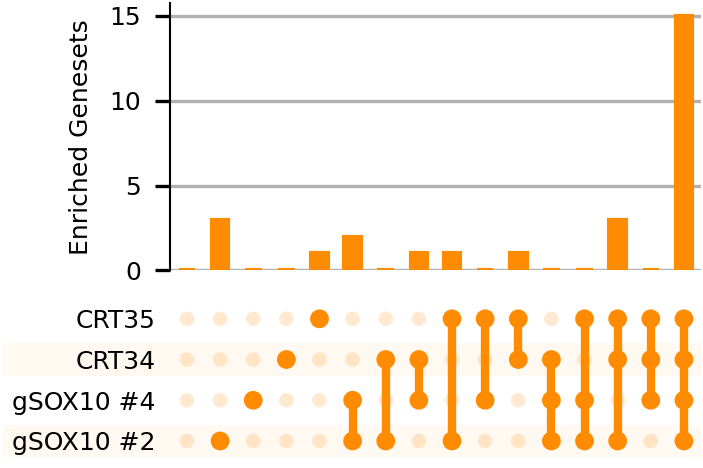

In [10]:
gsea_upset_expanded.plot()
plt.ylabel('Enriched Genesets')
plt.gcf().set_size_inches(3,2)

In [11]:
# Now repeating the process above but with DEGs
condsOI = ['4-11_v_A375','CRT34_v_A375', '2-18_v_A375','CRT35_v_A375']
comp_genes = {}
comp_down_genes = {}
for cond in condsOI:
    
    # A DEG is being defined as having a p-value <0.001 and log2FC > 2 due to how many are typically found (these are the same as what was used for the network separation)
    degs = set(data[(data['log2FoldChange_'+cond] > 2) & (data['padj_'+cond]< 0.001)]['ensembl_gene_id'].tolist())
    subtype = subtype_mapping[cond]
    comp_genes[subtype] = degs

    down_degs = set(data[(data['log2FoldChange_'+cond] < -2) & (data['padj_'+cond]< 0.001)]['ensembl_gene_id'].tolist())
    comp_down_genes[subtype] = down_degs


/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

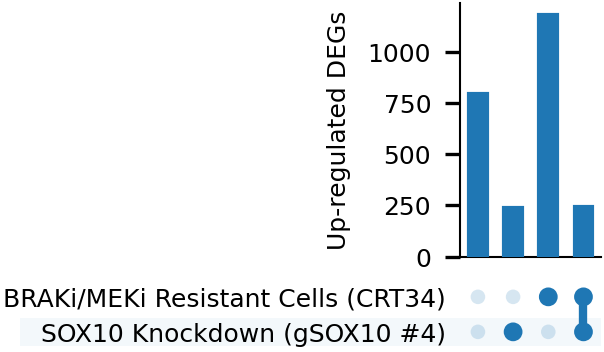

In [12]:
deg_upset = upsetplot.from_contents(comp_genes)
deg_upset.index.set_names(['SOX10 Knockdown (gSOX10 #4)','BRAKi/MEKi Resistant Cells (CRT34)','gSOX10 #2', 'CRT35'], inplace=True)
deg_upset_small = upsetplot.UpSet(deg_upset.droplevel(level=['gSOX10 #2','CRT35']), subset_size='count',facecolor = 'tab:blue', element_size=10, totals_plot_elements=0,sort_categories_by='input')

deg_upset_small.plot()
plt.ylabel('Up-regulated DEGs')
plt.gcf().set_size_inches(2.5,1.5)

# All below is for aesthetics to unify with my plots (will be adding the edgecolors after manually)
ax = plt.gca()
ax.grid(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(0.5)
#plt.savefig('Figures/Manuscript Figures/Figure deDANSY/Up_DEGs_overlap_condensed.svg')

# deDANSy Characterization of the SOX10 datasets of interest

Here, we begin to focus only on the gSOX10 #4 and CRT34 cells as representatives for the other two lines as these consistently showed differences and had distinct subnetworks from one another. These results were obtained previously and also shown in the deDANSy_All_Examples notebook, which were run on the UVA High performance computing system. Using deDANSy in the command line with the prompts:

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_large_set CRT34_v_A375 CRT35_v_A375 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_medium_set CRT34_v_4-11 CRT34_v_2-18 CRT35_v_4-11 CRT35_v_2-18 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_small_set 4-11_v_A375 2-18_v_A375 4-11_v_2-18 -mp 8 -sN 100 -fN 50 --seed 882 -fc 2 -a 0.001

    python ngram_min_test.py DEG_data/SOX10_invasion_DEG_Results.csv deDANSy_Results/sox10_diff_set CRT35_v_CRT34 CRT34_v_CRT34drug CRT35_v_CRT35drug -mp 8 -sN 100 -fN 50 --seed 882 -fc 1 -a 0.01

The fully expanded result is in the deDANSy_All_Examples notebook. Here, we will only focus on the CRT34 and gSOX10 #4 cell lines and plot results involving them only.

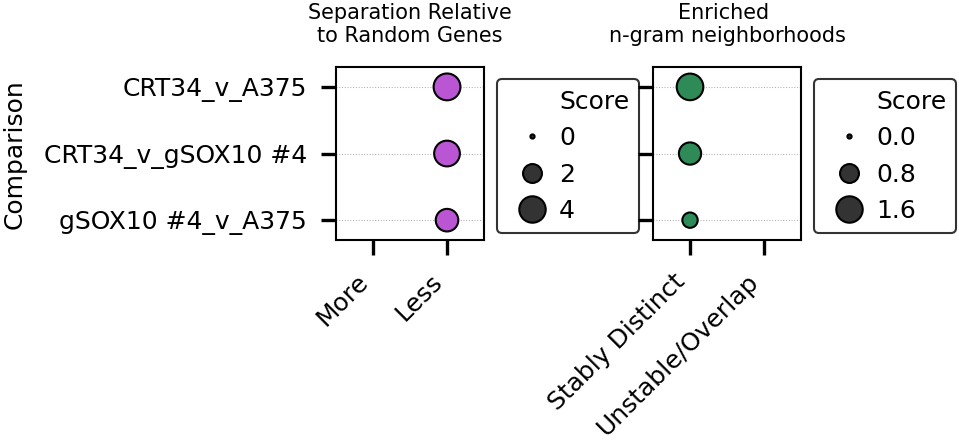

In [ ]:
# Importing the data to be plotted
files = ['sox10_diff_set','sox10_large_set', 'sox10_medium_set', 'sox10_small_set']
dataset = pd.DataFrame()
for file in files:
    filename = 'deDANSy_Results/' + file+ '_Results_Summary_Stats.csv'
    temp = pd.read_csv(filename)
    dataset = pd.concat([dataset, temp])
res = format_results(dataset)

# Replacing some of the labels to make them more clear
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('2-18', 'gSOX10 #2') if '2-18' in x else x)
res['Comparison']=res['Comparison'].apply(lambda x: x.replace('4-11', 'gSOX10 #4') if '4-11' in x else x)

compsOI = ['gSOX10 #4_v_A375',  'CRT34_v_A375','CRT34_v_gSOX10 #4']
resOI = res[res['Comparison'].isin(compsOI)]
axs = plot_functional_scores(resOI, False)
plt.gcf().set_size_inches(w=2.5,h=.75)

for i,_ in enumerate(axs):
    axs[i].margins(y = 0.15)


#plt.suptitle('SOX10-Deficient Dormant-Invasive Phenotype (GSE180568)\nCapparelli, et al 2022', y = 1.15)
#plt.savefig('Figures/Manuscript Figures/Figure deDANSY/SOX10_Example_Analysis.svg')

## Follow-up n-gram enrichment analysis to further elaborate on what deDANSy is summarizing and new insights it is generating.

The deDANSy results find the domain language subnetworks of the DEGs are less separated than by random chance suggesting the functions are well coordinated. Additionally, the deDANSy results suggest there are stably distinct subnetworks that define each phenotype relative to the parental controls and when compared to one another. This suggests that the two cell lines are potentially using different methods to establish the same phenotype. Here, we use n-gram enrichment that underlies the deDANSy analysis to explore what are the potentially different functional subnetworks that differ between the cells.

In [ ]:
# Setting up a deDANSy object for the dataset and then finding the enriched n-grams
deg_dansy = ngramNets.DEdansy(data, gene_ID_conv,uniprot_ref=complete_ref, data_ids='ensembl_gene_id')

# Setting the random seed for reproducibility
random.seed(123)

hyper_ress = {}
labs = {'4-11_v_A375':['gRNA_SOX10 #4', 'A375'], 'CRT34_v_A375':['CRT34', 'A375']}
for c in ['4-11_v_A375','CRT34_v_A375']:
    deg_dansy.calc_DEG_ngrams(data_cols=['log2FoldChange_'+c,'padj_'+c],alpha=0.001,fc_thres=2,batch_mode=True)
    # For later
    true_up = deg_dansy.up_DEGs
    true_dn = deg_dansy.down_DEGs
    
    up_hyper = deg_dansy.ngram_DEG_hypergeom('Up')
    dn_hyper = deg_dansy.ngram_DEG_hypergeom('Down')

    # Now generating the random gene list of DEGs
    total_degs = len(deg_dansy.up_DEGs)+len(deg_dansy.down_DEGs)
    frac_up = len(deg_dansy.up_DEGs)/total_degs

    rand_genes = deg_dansy.retrieve_random_ids(total_degs,iters=200)
    rand_dist_ngrams_pvals = {'Up':{},'Down':{}}
    for i in tqdm(range(100)):
        cur_DEGs = next(rand_genes)
        orig_up = random.sample(cur_DEGs, k=round(len(cur_DEGs)*frac_up))
        orig_dn = list(set(cur_DEGs).difference(orig_up))
        deg_dansy.set_DEG_ngrams(up_DEGs=orig_up, down_DEGs=orig_dn, verbose=False)
        rand_up_hyper = deg_dansy.ngram_DEG_hypergeom('Up')
        rand_dn_hyper = deg_dansy.ngram_DEG_hypergeom('Down')
        for j,c_dir in zip([rand_up_hyper,rand_dn_hyper],['Up','Down']):
            for node in j:
                if node not in rand_dist_ngrams_pvals[c_dir]:
                    rand_dist_ngrams_pvals[c_dir][node] = []
                rand_dist_ngrams_pvals[c_dir][node].append(j[node])

    hyper_results = {'Up':up_hyper,'Down':dn_hyper}
    fpr_dict = calc_ngram_fpr_vals(hyper_results, rand_dist_ngrams_pvals)
    resOI = gather_enrichment_results({'Up':up_hyper,'Down':dn_hyper}, fpr_dict)
    
    hyper_ress[c] = resOI

    del resOI

Starting to fetch n-grams.
Finished getting all n-grams
Starting to generate adjacency
Finished building adjacency.
Building the reference network information.


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


In [16]:
# For plotting purposes will only plot the n-grams that are not redundant
c  = '4-11_v_A375'
resOI = hyper_ress[c]
temp = get_max_info_enriched_ngrams(resOI, labs[c], q = 0.15)
full_ngram_cands= set(temp['ngram'])

c = 'CRT34_v_A375'
resOI = hyper_ress[c]
temp = get_max_info_enriched_ngrams(resOI, labs[c], q = 0.15)
overlap_ngram_cands = full_ngram_cands.intersection(temp['ngram'])
full_ngram_cands.update(temp['ngram'])

In [17]:
# Now for the n-grams that overlap between the top 15% seeing which ones occur in all the conditions of each comparison
ocom_ngrams = []
both_up = []
both_dn = []
for ngram in overlap_ngram_cands:
    potential_both_up = False
    potential_both_down = False
    potential_common_present = False
    for c in ['4-11_v_A375', 'CRT34_v_A375']:
        resOI = hyper_ress[c]
        ngram_res = resOI[resOI['ngram'] == ngram]
        if len(ngram_res) == 2:
            if potential_common_present:
                ocom_ngrams.append(ngram)
            else:
                potential_common_present= True
        elif all(ngram_res['variable'] == 'Up'):
            if potential_both_up:
                both_up.append(ngram)
            else:
                potential_both_up= True
        elif all(ngram_res['variable'] == 'Down'):
            if potential_both_down:
                both_dn.append(ngram)
            else:
                potential_both_down= True
ocom_ngrams = list(set(ocom_ngrams))

# Now repeating the above to finding the unique ones. For these will only focus on those that are up regulated relative to the control
unique_grna = []
unique_crt = []
unique_ngrams = full_ngram_cands.difference(overlap_ngram_cands)
for ngram in unique_ngrams:
    for c in ['4-11_v_A375', 'CRT34_v_A375']:
        resOI = hyper_ress[c]
        ngram_res = resOI[resOI['ngram'] == ngram]
        if all(ngram_res['variable'] == 'Up') and len(ngram_res) == 1:
            if c == '4-11_v_A375':
                unique_grna.append(ngram)
            else:
                unique_crt.append(ngram)
        elif all(ngram_res['variable'] == 'Down') and len(ngram_res) == 1 and all(ngram_res['-log10(p)'] >= 2): # Only for the downregulated ones will have a cutoff
            if c == '4-11_v_A375':
                unique_grna.append(ngram)
            else:
                unique_crt.append(ngram)

# Now that the candidates have been chosen will choose the ones for the plot (Note this should be highly repetitive)
a = hyper_ress['4-11_v_A375']
b = hyper_ress['CRT34_v_A375']
ocom_means = {}
both_up_means = {}
both_dn_means = {}
plot_ngrams = []
for ngram_set, d in zip([ocom_ngrams,both_up, both_dn],[ocom_means, both_up_means,both_dn_means]):
    for ngram in ngram_set:
        a1 = a[a['ngram'] == ngram]['-log10(p)'].tolist()
        b1 = b[b['ngram'] == ngram]['-log10(p)'].tolist()
        m = np.mean(a1+b1)
        d[ngram] = m

    d = dict(sorted(d.items(), key=lambda x: x[1],reverse=True))
    x = list(d.keys())[0:6]
    for i in x:
        if i not in plot_ngrams:
            plot_ngrams.append(i)

# Now repeating for the "unique" ones
a1 = a[a['ngram'].isin(unique_grna)]
unique_grna_vals = dict(zip(a1['ngram'],a1['-log10(p)']))
unique_grna_vals = dict(sorted(unique_grna_vals.items(), key = lambda x:x[1], reverse=True))
for i in list(unique_grna_vals.keys())[0:6]:
        if i not in plot_ngrams:
            plot_ngrams.append(i)


b1 = b[b['ngram'].isin(unique_crt)]
unique_crt_vals = dict(zip(b1['ngram'],b1['-log10(p)']))
unique_crt_vals = dict(sorted(unique_crt_vals.items(), key = lambda x:x[1], reverse=True))
for i in list(unique_crt_vals.keys())[0:6]:
        if i not in plot_ngrams:
            plot_ngrams.append(i)

In [18]:
# Now creating the plot data in an easy to plot dataframe
grna_plotting_res = hyper_ress['4-11_v_A375'].copy()
grna_plotting_res = grna_plotting_res[grna_plotting_res['ngram'].isin(plot_ngrams)]

crt_plotting_res = hyper_ress['CRT34_v_A375'].copy()
crt_plotting_res = crt_plotting_res[crt_plotting_res['ngram'].isin(plot_ngrams)]

# Now adding in a few dummy variables that help with plotting
ngram_order = {n:i for i, n in enumerate(plot_ngrams)}
grna_plotting_res['ngram_order'] = grna_plotting_res['ngram'].map(ngram_order)
crt_plotting_res['ngram_order'] = crt_plotting_res['ngram'].map(ngram_order)

grna_plotting_res['var_order'] = grna_plotting_res['variable'].map({'Up':0, 'Down':1})
crt_plotting_res['var_order'] = crt_plotting_res['variable'].map({'Up':0, 'Down':1})

# For both of the dataframes adding dummy rows that will ensure they have the same size scale in the enrichment plot
top_val = np.ceil(max(grna_plotting_res['-log10(p)'].tolist() + crt_plotting_res['-log10(p)'].tolist()))
fillin_values = np.linspace(0,top_val,num=5)
new_df = pd.DataFrame(columns=grna_plotting_res.columns)
new_df['-log10(p)'] = fillin_values

grna_plotting_res = pd.concat([grna_plotting_res, new_df])
crt_plotting_res = pd.concat([crt_plotting_res, new_df])

# Filtering out any non-significant results
grna_plotting_res= grna_plotting_res[(grna_plotting_res['FPR'] <= 0.05) & (grna_plotting_res['p']<= 0.05)]
crt_plotting_res= crt_plotting_res[(crt_plotting_res['FPR'] <= 0.05) & (crt_plotting_res['p']<= 0.05)]

/var/folders/3q/_kyvxhrx2zv25qm8x2nv6c0h0000gr/T/ipykernel_45729/3840242798.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  grna_plotting_res = pd.concat([grna_plotting_res, new_df])
/var/folders/3q/_kyvxhrx2zv25qm8x2nv6c0h0000gr/T/ipykernel_45729/3840242798.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  crt_plotting_res = pd.concat([crt_plotting_res, new_df])


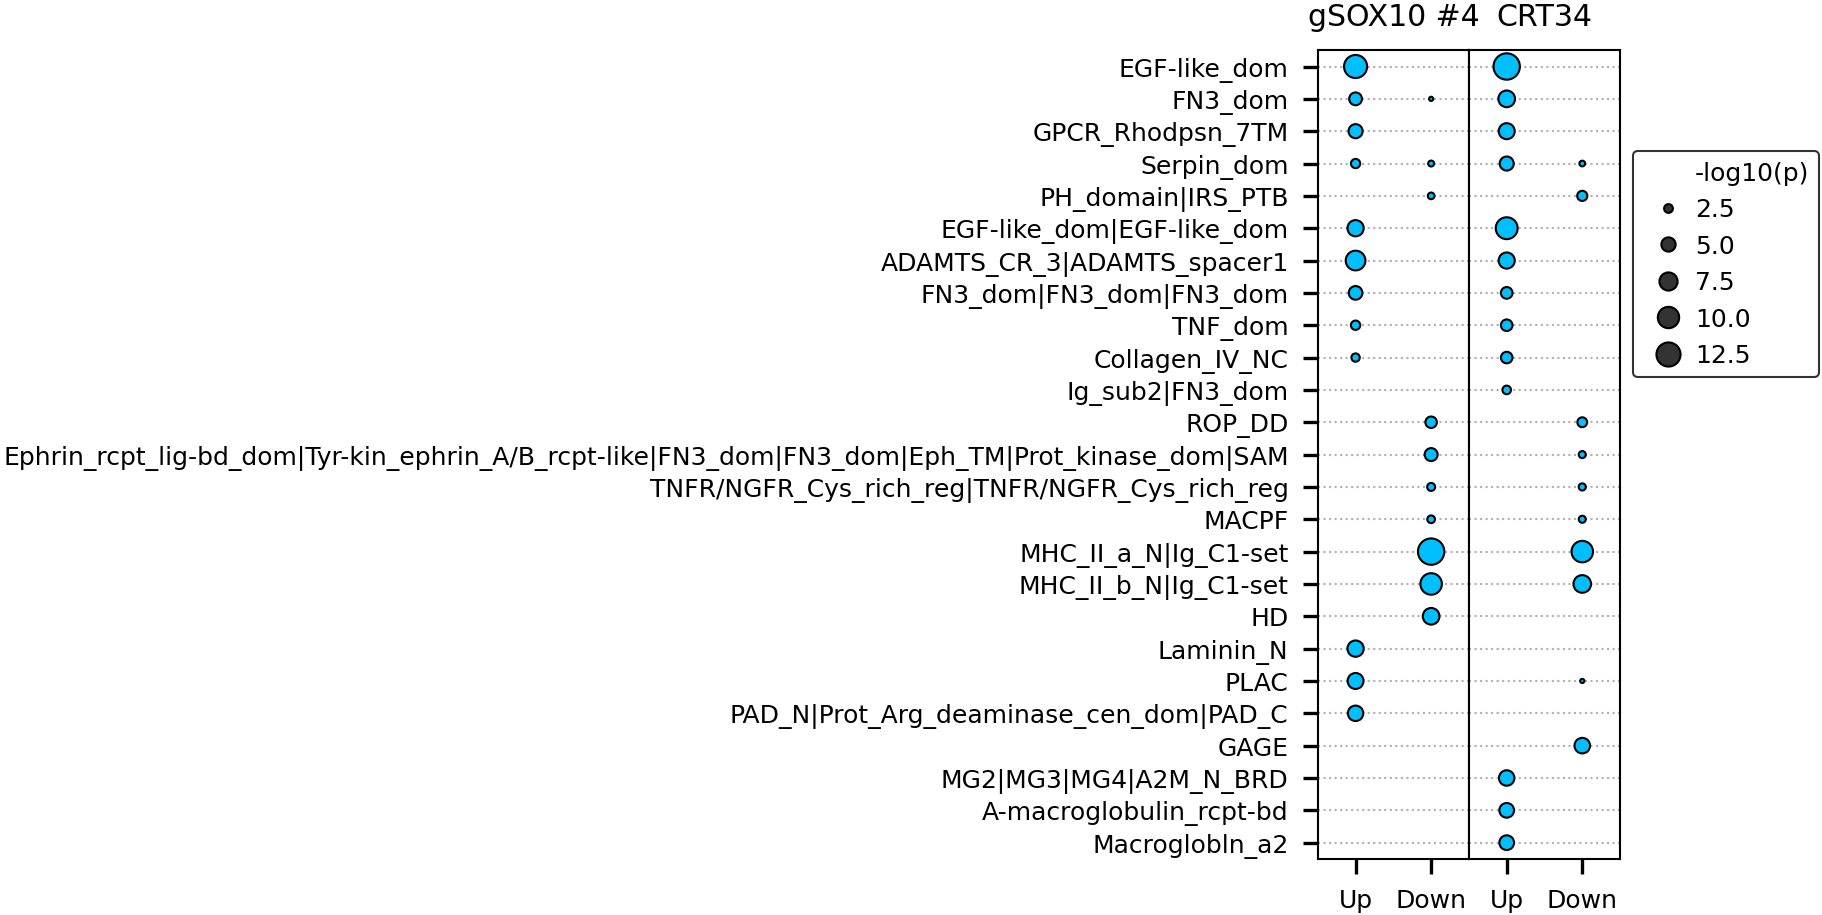

In [19]:
plt.figure(figsize=(1.3,3.5))
plt.subplot(1,2,1)
plot_enriched_ngrams_presorted(grna_plotting_res, deg_dansy,x_order = 'var_order', ngram_ticks=ngram_order, show_FPR=False)
plt.title('gSOX10 #4')
plt.xticks(ticks = [0,1], labels=['Up','Down'])
plt.xlim(-0.5,1.5)
plt.gca().get_legend().remove()

plt.gca().grid(True, axis = 'y', linestyle = ':', linewidth = 0.5)
plt.subplot(1,2,2)
plot_enriched_ngrams_presorted(crt_plotting_res, deg_dansy,x_order = 'var_order', ngram_ticks=ngram_order, bbox_to_anchor = (1,0.58) , show_FPR=False)
plt.title('CRT34')
plt.gca().grid(True, axis = 'y',linestyle = ':', linewidth =0.5)
plt.tick_params('y',length=0, labelleft=False)
plt.xticks(ticks = [0,1], labels=['Up','Down'])
plt.xlim(-0.5,1.5)

plt.subplots_adjust(wspace=0)
#plt.savefig('Figures/Manuscript Figures/Figure deDANSY/Sox10_ngram_enrichment_comparison_plot.svg')

In [20]:
# Using an UpSet plots to show the overlap in significantly and FPR < 0.05 n-grams shared between the two
grna_up_enriched = hyper_ress['4-11_v_A375'].copy()
grna_up_enriched = grna_up_enriched[(grna_up_enriched['variable'] == 'Up') & (grna_up_enriched['p'] <= 0.05) & (grna_up_enriched['FPR'] <= 0.05)]['ngram'].tolist()
grna_dn_enriched = hyper_ress['4-11_v_A375'].copy()
grna_dn_enriched = grna_dn_enriched[(grna_dn_enriched['variable'] == 'Down') & (grna_dn_enriched['p'] <= 0.05) & (grna_dn_enriched['FPR'] <= 0.05)]['ngram'].tolist()
crt_up_enriched = hyper_ress['CRT34_v_A375'].copy()
crt_up_enriched = crt_up_enriched[(crt_up_enriched['variable'] == 'Up') & (crt_up_enriched['p'] <= 0.05) & (crt_up_enriched['FPR'] <= 0.05)]['ngram'].tolist()
crt_dn_enriched = hyper_ress['CRT34_v_A375'].copy()
crt_dn_enriched = crt_dn_enriched[(crt_dn_enriched['variable'] == 'Up') & (crt_dn_enriched['p'] <= 0.05) & (crt_dn_enriched['FPR'] <= 0.05)]['ngram'].tolist()

# Placing into separate dictionaries
up_sig_ngrams = {'gSOX10 #4':grna_up_enriched, 'CRT34':crt_up_enriched}
dn_sig_ngrams = {'gSOX10 #4':grna_dn_enriched, 'CRT34':crt_dn_enriched}

/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

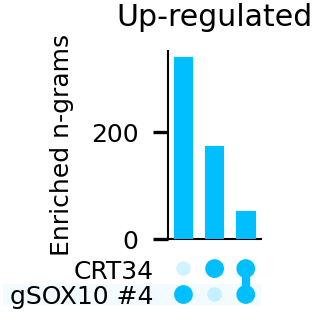

In [21]:

up_ngram_upset = upsetplot.from_contents(up_sig_ngrams)
up_ngram_upset_p = upsetplot.UpSet(up_ngram_upset, subset_size='count',facecolor = 'deepskyblue', totals_plot_elements=0, element_size=10,sort_by='degree',sort_categories_by='input')
up_ngram_upset_p.plot()
plt.ylabel('Enriched n-grams')
plt.title('Up-regulated')
ax = plt.gca()
ax.grid(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(0.5)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Up_enriched_ngrams.svg')

/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/yzv6ek/miniforge3/envs/dansy/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

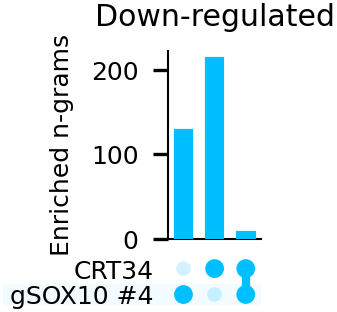

In [22]:
dn_ngram_upset = upsetplot.from_contents(dn_sig_ngrams)
dn_ngram_upset_p = upsetplot.UpSet(dn_ngram_upset, subset_size='count',facecolor = 'deepskyblue', totals_plot_elements=0, element_size=10, sort_by='degree', sort_categories_by='input')
dn_ngram_upset_p.plot()
plt.ylabel('Enriched n-grams')
plt.title('Down-regulated')
ax = plt.gca()
ax.grid(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(0.5)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Down_enriched_ngrams.svg')

## Now finding the enriched n-grams of the Hallmark gene sets.

Here, we explore how unique or widespread the domain n-grams are for the Hallmark gene sets to compare deDANSy findings relative to GSEA

In [25]:
# Now for those top genesets seeing which n-grams naturally are enriched as well
random.seed(882)
hall_enrich_ngram_pvals = {}
hall_random_ngram_pvals = {}
for hallmark in hall_conv:
    hall_random_ngram_pvals[hallmark] = {}
    prots = hall_conv[hallmark]
    numProts = len(prots)
    hall_enrich = ngramNets.ngram_enrichment(deg_dansy, prots)
    hall_enrich_ngram_pvals[hallmark] = hall_enrich
    rand_genes = deg_dansy.retrieve_random_ids(numProts,iters=200)

    for i in tqdm(range(100), leave=False, desc=f'Random for {hallmark}'):
        cur_DEGs = next(rand_genes)
        rand_enrich = ngramNets.ngram_enrichment(deg_dansy, cur_DEGs)
        
        for node in rand_enrich:
            if node not in hall_random_ngram_pvals[hallmark]:
                hall_random_ngram_pvals[hallmark][node] = []
            hall_random_ngram_pvals[hallmark][node].append(rand_enrich[node])

hallmark_fpr = calc_ngram_fpr_vals(hall_enrich_ngram_pvals, hall_random_ngram_pvals)

In [26]:
hall_enrich_fpr = gather_enrichment_results(hall_enrich_ngram_pvals,hallmark_fpr)
hall_full_max = get_max_info_enriched_ngrams(hall_enrich_fpr, q = 0.02)

In [27]:
# Putting the n-grams in order of how many genesets they are in

ng_geneset_dist = Counter(hall_full_max['ngram'])
ng_geneset_dist = dict(ng_geneset_dist)
# Getting the n-grams that are 4 or fewer for the plot to filter the enrichment plot a little
filt_ngrams = [deg_dansy.return_legible_ngram(x) for x in ng_geneset_dist]
filt_ngram_labs = [deg_dansy.return_legible_ngram(x) if len(x.split('|')) <=2 else '' for x in ng_geneset_dist ]


In [28]:
import scipy.cluster.hierarchy as hierarchy

In [30]:
hall_test = pd.pivot(hall_full_max, columns=['variable'], index='ngram',values='-log10(p)').fillna(0)

ld = hierarchy.linkage(hall_test, method='ward')
index_order = hierarchy.leaves_list(ld)

ld = hierarchy.linkage(hall_test.transpose(), method='ward')
column_order = hierarchy.leaves_list(ld)
# Now mapping the above to create the bubble plot in a specific order
index_map_order = {hall_test.index[j]:i for i,j in enumerate(index_order)}
column_map_order = {hall_test.columns[j]:i for i,j in enumerate(column_order)}
filt_ngram_clust_labs = [deg_dansy.return_legible_ngram(x) if len(x.split('|')) <=2 else '' for x in index_map_order.keys()]
# Now putting the order into the original data frame
hall_full_max['ngram_order'] = hall_full_max['ngram'].map(index_map_order)
hall_full_max['geneset_order'] = hall_full_max['variable'].map(column_map_order)

Text(0.5, 0.9, 'Top 2% Enriched n-grams across the Hallmarks genesets')

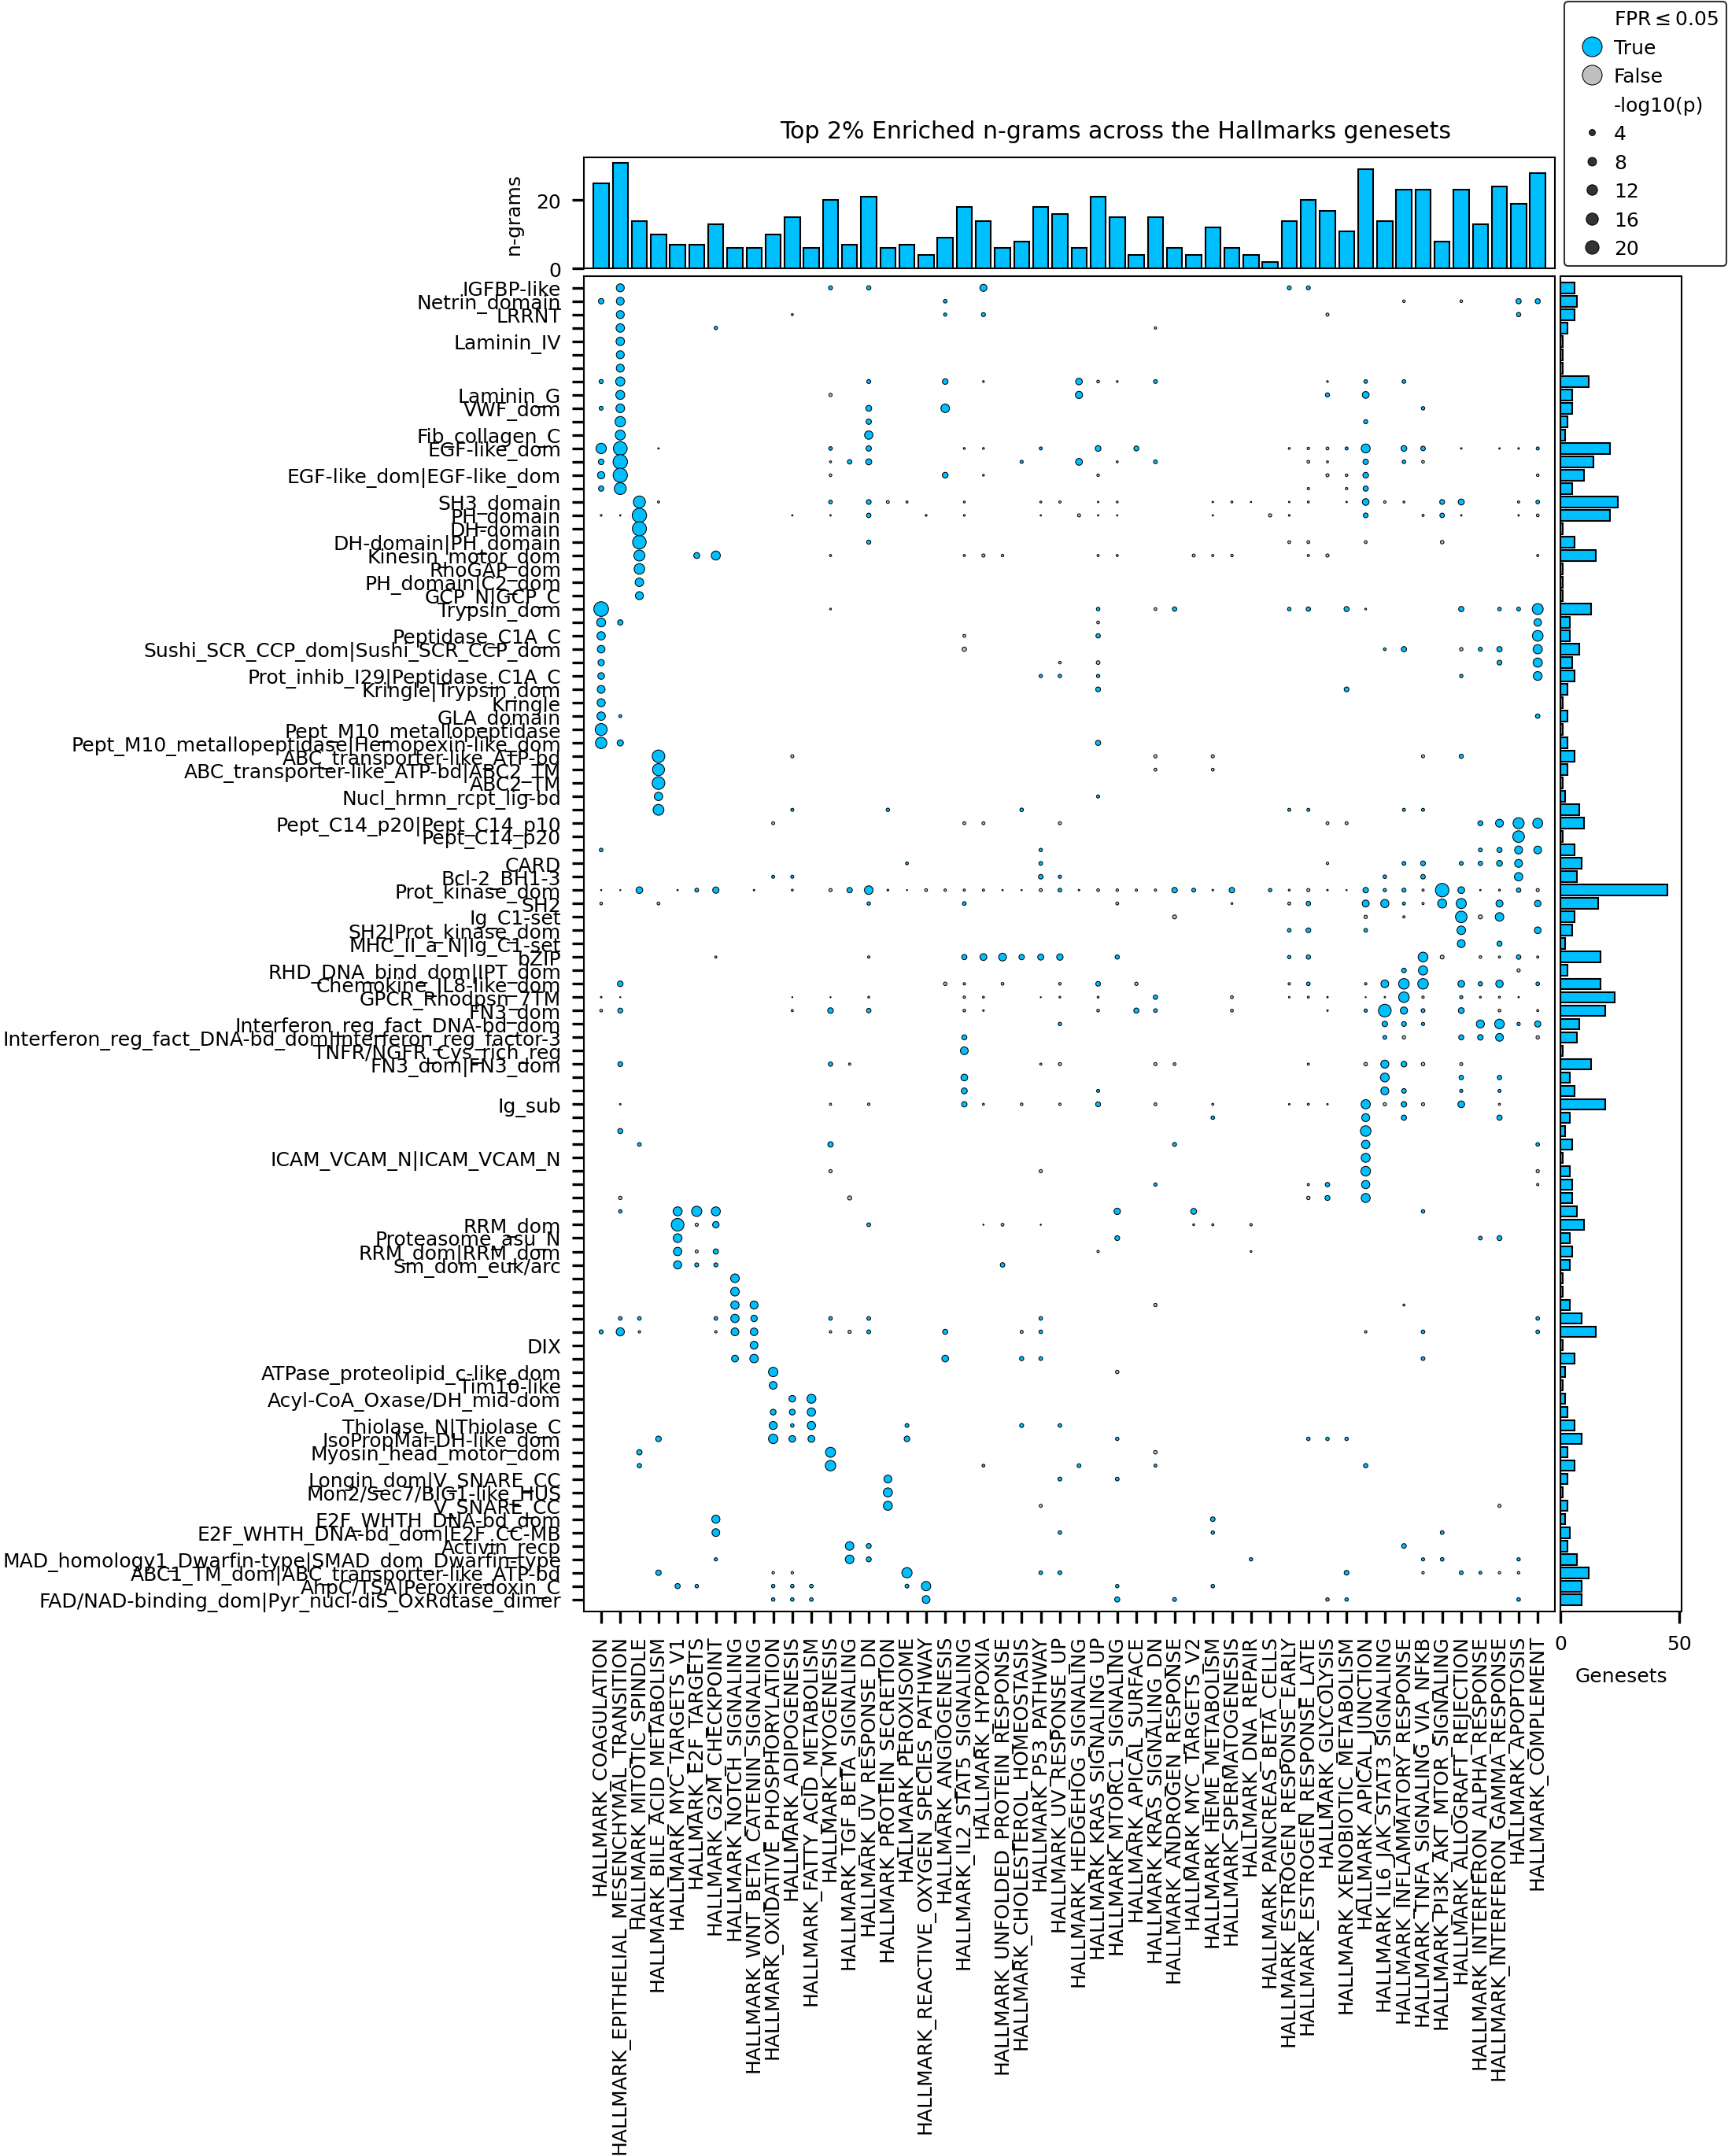

In [31]:
# Making a large figure that contains the individual n-gram enrichment and the number of n-grams/genesets each correspond to on the different axes
f, axs = plt.subplot_mosaic('''A.
                            BC''',figsize = (6,8), height_ratios = [0.5,6], width_ratios = [4,0.5],subplot_kw={'xmargin':0.01})
axs['A']._shared_axes['x'].join(axs['A'], axs['B'])
axs['C']._shared_axes['y'].join(axs['C'], axs['B'])

geneset_dist = dict(Counter(hall_full_max['variable']))
# Putting the geneset counts in the same order as the sorted matrix
gs_order = [column_map_order[g] for g in geneset_dist]
axs['A'].bar(x = gs_order, height = geneset_dist.values(), linewidth = 0.5, edgecolor='k', color='deepskyblue')
axs['A'].tick_params('x', bottom=False, labelbottom=False)
axs['A'].set_ylabel('n-grams')

ng_order = [index_map_order[g] for g in ng_geneset_dist]
axs['C'].barh(y =ng_order, width = ng_geneset_dist.values(), linewidth = 0.5, edgecolor='k',color='deepskyblue')
axs['C'].invert_yaxis()
axs['C'].set_xlim(0,51)
axs['C'].tick_params('y', left=False, labelleft = False)

plot_enriched_ngrams_presorted(hall_full_max,deg_dansy,ax = axs['B'],sizes = (.1,20), linewidth = 0.25)
axs['B'].set_xticks(rotation=90, ticks=[v for v in column_map_order.values()], labels = [k for k in column_map_order.keys()])
axs['B'].set_yticks(ticks=[v for v in index_map_order.values()], labels=filt_ngram_clust_labs)
axs['B'].margins(y = 0.005)
axs['B'].set_xlabel(None)
axs['B'].set_ylabel(None)
axs['C'].set_xlabel('Genesets')
f.subplots_adjust(hspace=0.01,wspace=0.01)
plt.suptitle('Top 2% Enriched n-grams across the Hallmarks genesets',y=0.9)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Hallmarks Analysis/Enriched_ngrams_Hallmarks.svg')

The above n-gram enrichment bubble plot shows there are some key n-grams for each gene set but are often shared amongst similar gene sets. Further, it also highlights that most n-grams will map to multiple gene sets. Therefore, we ask if all the enriched domain n-grams of our conditions all map to the gene sets we use.

In [34]:
# Here doing the same as above but limiting it to n-grams found within the top X percent of significant n-grams for the DEGs to show how well (or not) they connect to the genesets in question
hallmark_max_info = get_max_info_enriched_ngrams(hall_enrich_fpr,q=1) # Getting a larger fraction to increase the odds of getting some of the DEG n-grams
resOI = hyper_ress['4-11_v_A375'] # Using this one to just start off the next couple of plots
max_res = get_max_info_enriched_ngrams(resOI, deg_labels, .05)
plotted_ngrams = max_res['ngram'].tolist()

hallmark_overlap_fpr = hallmark_max_info[hallmark_max_info['ngram'].isin(plotted_ngrams)]
max_res = hallmark_overlap_fpr.copy()
enriched_genesets = comp_sets_full['gSOX10 #4']
filt_res = max_res[max_res['variable'].isin(enriched_genesets)].copy()
# Now taking these n-grams of interest and putting them in order based off hierarchical clustering
max_res_pivot = pd.pivot(filt_res, columns=['variable'], index = 'ngram', values='-log10(p)').fillna(0)
ld = hierarchy.linkage(max_res_pivot, method='ward')
index_order= hierarchy.leaves_list(ld)
ld = hierarchy.linkage(max_res_pivot.transpose(), method = 'ward')
column_order = hierarchy.leaves_list(ld)

index_map_order = {max_res_pivot.index[j]:i for i,j in enumerate(index_order)}
# Now readding any of the n-grams did not have genesets they mapped to
missing_ngrams = set(plotted_ngrams).difference(index_map_order.keys())
missing_index_order = {x:i for i,x in enumerate(missing_ngrams,start=len(index_map_order))}
index_map_order = {**index_map_order, **missing_index_order}

# Now repeating with the genesets
column_map_order = {max_res_pivot.columns[j]:i for i,j in enumerate(column_order)}
missing_genesets = set(enriched_genesets).difference(column_map_order.keys())
missing_genesets_order = {x:i for i,x in enumerate(missing_genesets, start=len(column_map_order))}
column_map_order = {**column_map_order,**missing_genesets_order}

ngram_plot_names = {node:deg_dansy.return_legible_ngram(node) for node in filt_res['ngram'].tolist()}
filt_ngram_clust_labs = [deg_dansy.return_legible_ngram(x) for x in index_map_order.keys()]
filt_res['ngram_order'] = filt_res['ngram'].map(index_map_order)
filt_res['geneset_order'] = filt_res['variable'].map(column_map_order)


In [35]:
replacement_labels = []
for i,ngram in enumerate(filt_ngram_clust_labs):
    if len(ngram.split('|')) > 3:
        ngram_split = ngram.split('|')
        if len(set(ngram_split)) == 1:
           n_rep = list(set(ngram_split))
           n_rep = str(n_rep[0])
           n_times = len(ngram_split)
           new_lab = n_rep+' x ' +str(n_times)
           replacement_labels.append((i,new_lab))
        

for i, new_lab in replacement_labels:
    filt_ngram_clust_labs[i] = new_lab

Text(0.5, 0.92, 'Enriched n-grams of gSOX10 #4')

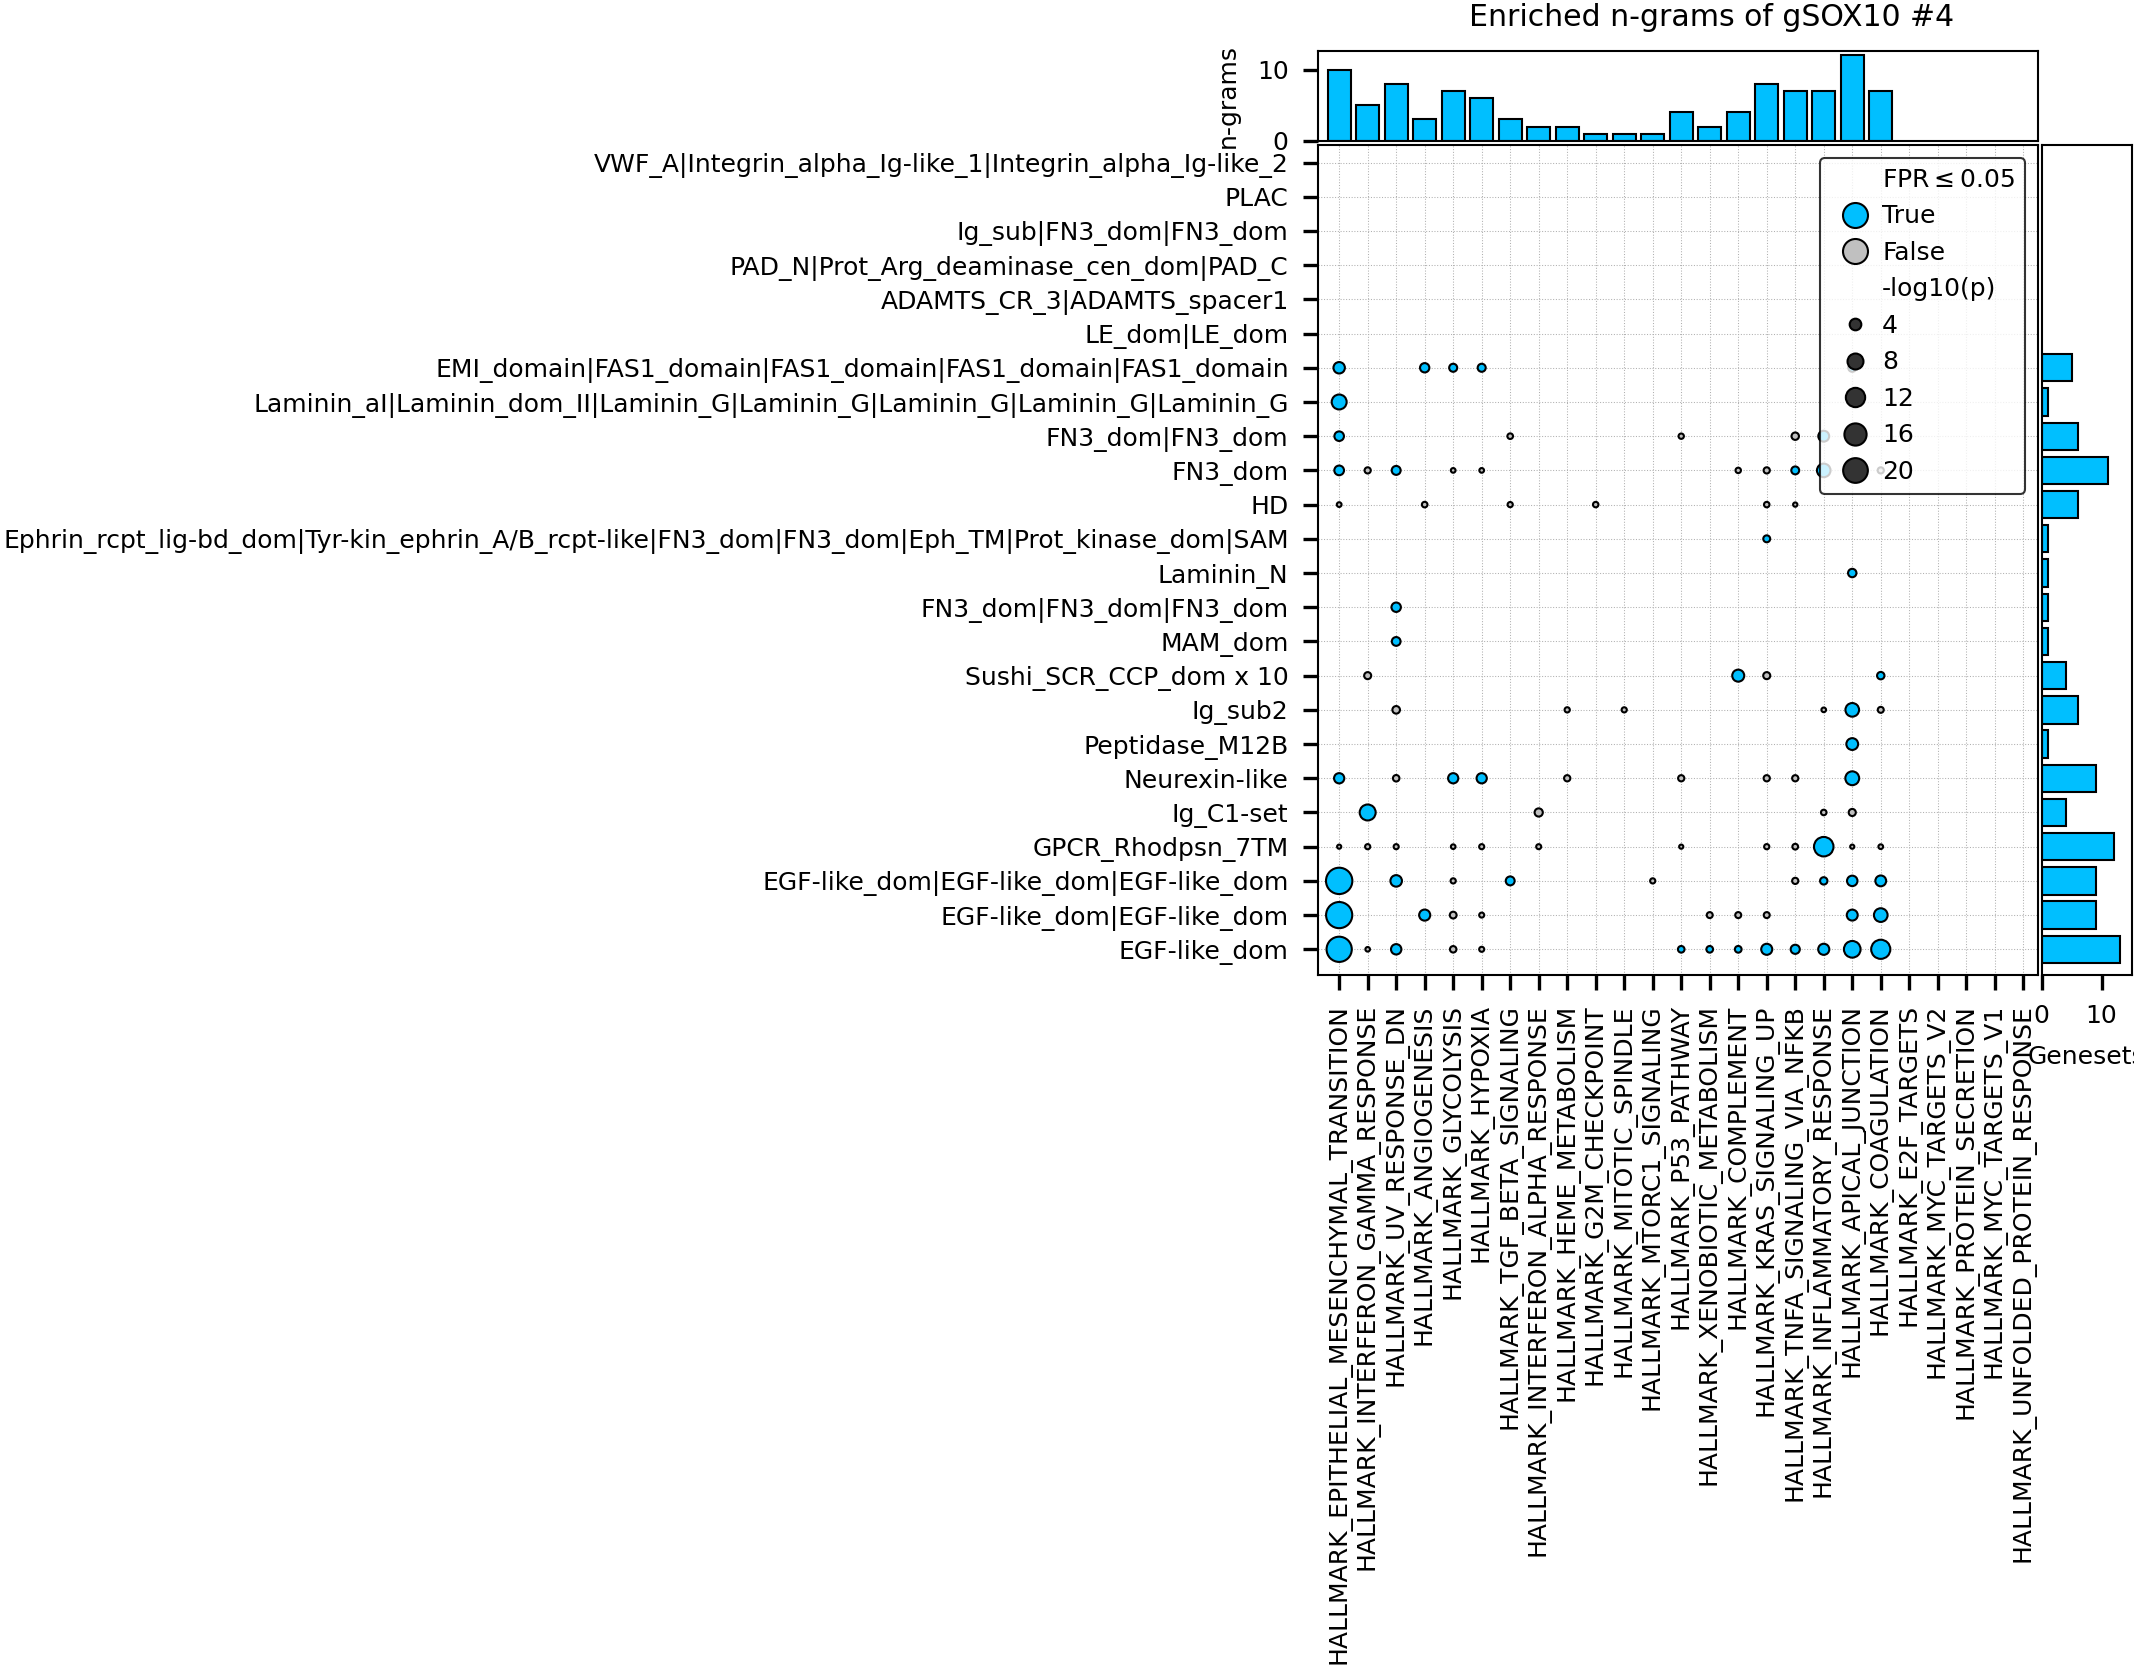

In [36]:

f, axs = plt.subplot_mosaic('''A.
                            BC''',figsize = (3.5,4), height_ratios = [0.65,6], width_ratios = [4,0.5],subplot_kw={'xmargin':0.01})
axs['A']._shared_axes['x'].join(axs['A'], axs['B'])
axs['C']._shared_axes['y'].join(axs['C'], axs['B'])

geneset_dist = dict(Counter(filt_res['variable']))
# Putting the geneset counts in the same order as the sorted matrix
gs_order = [column_map_order[g] for g in geneset_dist]
axs['A'].bar(x = gs_order, height = geneset_dist.values(), linewidth = 0.5, edgecolor='k', color='deepskyblue')
axs['A'].tick_params('x', bottom=False, labelbottom=False)
axs['A'].set_ylabel('n-grams')
ng_geneset_dist = dict(Counter(filt_res['ngram']))
ng_order = [index_map_order[g] for g in ng_geneset_dist]
axs['C'].barh(y =ng_order, width = ng_geneset_dist.values(), linewidth = 0.5, edgecolor='k',color='deepskyblue')
axs['C'].invert_yaxis()
axs['C'].set_xlim(0,15)
axs['C'].tick_params('y', left=False, labelleft = False)

plot_enriched_ngrams_presorted(filt_res,deg_dansy,ax = axs['B'], loc ='upper right')
axs['B'].set_xticks(rotation=90, ticks=[v for v in column_map_order.values()], labels = [k for k in column_map_order.keys()])
axs['B'].set_yticks(ticks=[v for v in index_map_order.values()], labels=filt_ngram_clust_labs)
axs['B'].set_ylim(-0.75,len(filt_ngram_clust_labs)-0.5)
axs['B'].set_xlim(-0.75,len(enriched_genesets)-0.5)
axs['B'].grid(True, lw = 0.25, linestyle = ':')
axs['B'].set_xlabel(None)
axs['B'].set_ylabel(None)
axs['C'].set_xlabel('Genesets')
f.subplots_adjust(hspace=0.01,wspace=0.01)
plt.suptitle('Enriched n-grams of gSOX10 #4', y = 0.92)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Enriched_ngrams_geneset_overlap_gRNA.pdf')

Text(0.5, 0.92, 'Enriched n-grams of CRT34')

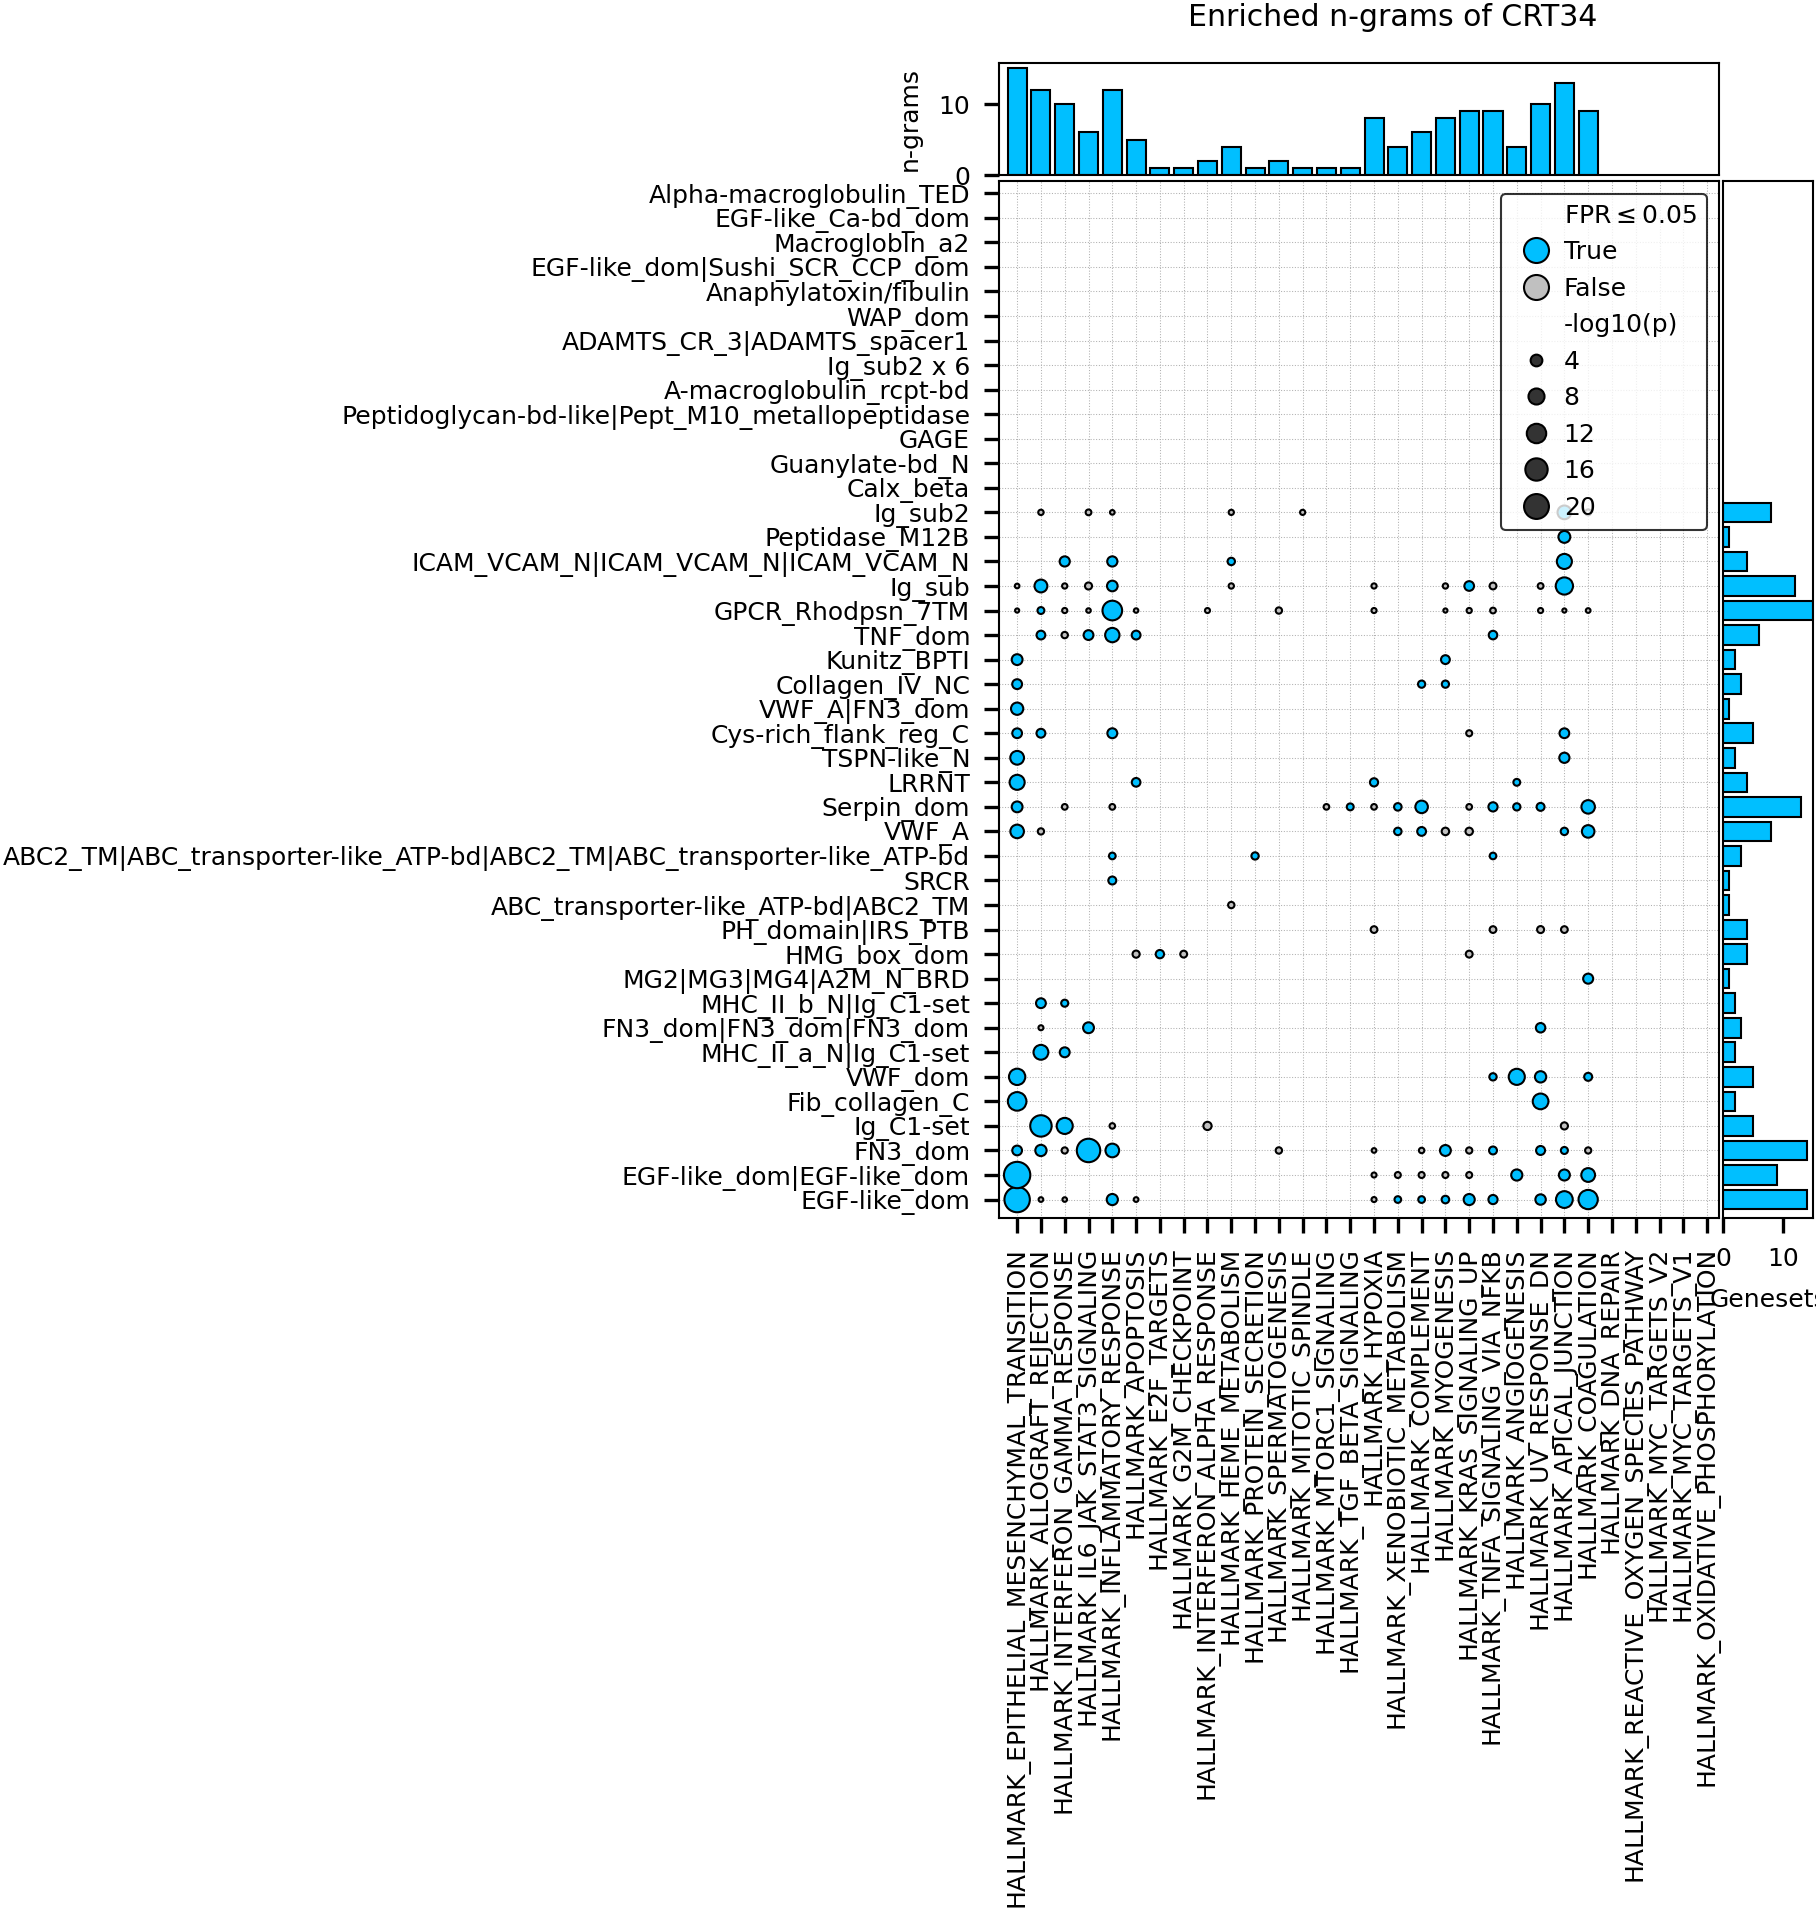

In [37]:
# Same as above but for the CRT34 cells
# Here doing the same as above but limiting it to n-grams found within the top X percent of significant n-grams for the DEGs to show how well (or not) they connect to the genesets in question

resOI = hyper_ress['CRT34_v_A375'] # Using this one to just start off the next couple of plots
max_res = get_max_info_enriched_ngrams(resOI, deg_labels, .05)
plotted_ngrams = max_res['ngram'].tolist()

hallmark_overlap_fpr = hallmark_max_info[hallmark_max_info['ngram'].isin(plotted_ngrams)]
max_res = hallmark_overlap_fpr.copy()
enriched_genesets = comp_sets_full['CRT34']
filt_res = max_res[max_res['variable'].isin(enriched_genesets)].copy()
# Now taking these n-grams of interest and putting them in order based off hierarchical clustering
max_res_pivot = pd.pivot(filt_res, columns=['variable'], index = 'ngram', values='-log10(p)').fillna(0)
ld = hierarchy.linkage(max_res_pivot, method='ward')
index_order= hierarchy.leaves_list(ld)
ld = hierarchy.linkage(max_res_pivot.transpose(), method = 'ward')
column_order = hierarchy.leaves_list(ld)

index_map_order = {max_res_pivot.index[j]:i for i,j in enumerate(index_order)}
# Now readding any of the n-grams did not have genesets they mapped to
missing_ngrams = set(plotted_ngrams).difference(index_map_order.keys())
missing_index_order = {x:i for i,x in enumerate(missing_ngrams,start=len(index_map_order))}
index_map_order = {**index_map_order, **missing_index_order}

# Now repeating with the genesets
column_map_order = {max_res_pivot.columns[j]:i for i,j in enumerate(column_order)}
missing_genesets = set(enriched_genesets).difference(column_map_order.keys())
missing_genesets_order = {x:i for i,x in enumerate(missing_genesets, start=len(column_map_order))}
column_map_order = {**column_map_order,**missing_genesets_order}

ngram_plot_names = {node:deg_dansy.return_legible_ngram(node) for node in filt_res['ngram'].tolist()}
filt_ngram_clust_labs = [deg_dansy.return_legible_ngram(x) for x in index_map_order.keys()]
filt_res['ngram_order'] = filt_res['ngram'].map(index_map_order)
filt_res['geneset_order'] = filt_res['variable'].map(column_map_order)


replacement_labels = []
for i,ngram in enumerate(filt_ngram_clust_labs):
    if len(ngram.split('|')) > 3:
        ngram_split = ngram.split('|')
        if len(set(ngram_split)) == 1:
           n_rep = list(set(ngram_split))
           n_rep = str(n_rep[0])
           n_times = len(ngram_split)
           new_lab = n_rep+' x ' +str(n_times)
           replacement_labels.append((i,new_lab))
        

for i, new_lab in replacement_labels:
    filt_ngram_clust_labs[i] = new_lab
    
f, axs = plt.subplot_mosaic('''A.
                            BC''',figsize = (3.5,5), height_ratios = [0.65,6], width_ratios = [4,0.5],subplot_kw={'xmargin':0.01})
axs['A']._shared_axes['x'].join(axs['A'], axs['B'])
axs['C']._shared_axes['y'].join(axs['C'], axs['B'])

geneset_dist = dict(Counter(filt_res['variable']))
# Putting the geneset counts in the same order as the sorted matrix
gs_order = [column_map_order[g] for g in geneset_dist]
axs['A'].bar(x = gs_order, height = geneset_dist.values(), linewidth = 0.5, edgecolor='k', color='deepskyblue')
axs['A'].tick_params('x', bottom=False, labelbottom=False)
axs['A'].set_ylabel('n-grams')
ng_geneset_dist = dict(Counter(filt_res['ngram']))
ng_order = [index_map_order[g] for g in ng_geneset_dist]
axs['C'].barh(y =ng_order, width = ng_geneset_dist.values(), linewidth = 0.5, edgecolor='k',color='deepskyblue')
axs['C'].invert_yaxis()
axs['C'].set_xlim(0,15)
axs['C'].tick_params('y', left=False, labelleft = False)

plot_enriched_ngrams_presorted(filt_res,deg_dansy,ax = axs['B'], loc ='upper right')
axs['B'].set_xticks(rotation=90, ticks=[v for v in column_map_order.values()], labels = [k for k in column_map_order.keys()])
axs['B'].set_yticks(ticks=[v for v in index_map_order.values()], labels=filt_ngram_clust_labs)
axs['B'].set_ylim(-0.75,len(filt_ngram_clust_labs)-0.5)
axs['B'].set_xlim(-0.75,len(enriched_genesets)-0.5)
axs['B'].grid(True, lw = 0.25, linestyle = ':')
axs['B'].set_xlabel(None)
axs['B'].set_ylabel(None)
axs['C'].set_xlabel('Genesets')
f.subplots_adjust(hspace=0.01,wspace=0.01)
plt.suptitle('Enriched n-grams of CRT34', y = 0.92)
#plt.savefig('Figures/Manuscript Figures/Supplemental Figure Expanded deDANSy/Enriched_ngrams_geneset_overlap_CRT.pdf')

For 4-11_v_A375 there are 243 ngrams that map to 0 which makes up 0.4550561797752809
For CRT34_v_A375 there are 82 ngrams that map to 0 which makes up 0.20147420147420148


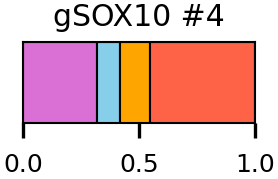

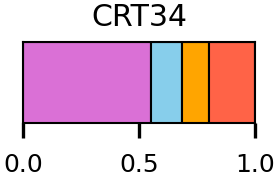

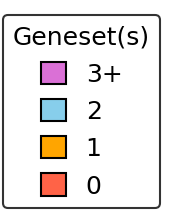

In [38]:
a = 0.05
plot_titles = {'4-11_v_A375':{'Title':'gSOX10 #4', 'filename':'gRNA_ngram_geneset_distribution.svg'},
               'CRT34_v_A375':{'Title':'CRT34', 'filename':'CRT_ngram_geneset_distribution.svg'}}
for comp, resOI in hyper_ress.items():
    

    ngram_4_hallmarks_check = resOI[resOI['p'] <= a]['ngram']
    # Setting up a network which contains all the n-grams of interest and the geneset(s) they correspond to.
    G = nx.Graph(name='Hallmark n-gram overlap')
    G.add_nodes_from(ngram_4_hallmarks_check, layer=0)
    G.add_nodes_from(hall_conv.keys(), layer= 1)
    
    # Now for each of the hallmarks checking which n-grams that are of interest overlap and creating an edge list for that
    edges_2_add = set()
    for gs in hall_conv.keys():
        deg_dansy.set_DEG_ngrams(up_DEGs=true_up, down_DEGs=hall_conv[gs], collapse=False, verbose=False)
        gs_ngrams = deg_dansy.down_ngrams
        overlap = set(gs_ngrams).intersection(ngram_4_hallmarks_check)
        edges_2_add.update([(i, gs) for i in overlap])
    G.add_edges_from(edges_2_add)
    
    # To show how many actually map will display a pie chart split into mapping to 3+, 2, 1, or 0
    ngram_map_results = {k:0 for k in ['3+','2','1','0']}

    for i in ngram_4_hallmarks_check:
        gs_all = list(nx.neighbors(G,i))
        if len(gs_all) >= 3:
            ngram_map_results['3+'] += 1
        else:
            num_n = str(len(gs_all))
            ngram_map_results[num_n] += 1

    t= pd.DataFrame().from_dict(ngram_map_results, orient='index')
    t[0] = t[0]/t[0].sum()
    t.T.plot.barh(stacked=True, edgecolor = 'k', lw = 0.5, color=['orchid','skyblue','orange', 'tomato'])
    plt.title(plot_titles[comp]['Title'],y=0.9)
    plt.gcf().set_size_inches(1,0.35)
    plt.tick_params(axis='y', left=False, labelleft = False)
    plt.xlabel(None)
    if comp == 'CRT34_v_A375':
        h, l = plt.gca().get_legend_handles_labels()
        plt.gca().get_legend().remove()
        plt.ylim(0,0.25)
        plt.margins(0,0)
  #      plt.savefig('Figures/Manuscript Figures/Figure deDANSY/'+plot_titles[comp]['filename'])
        #plt.close()
        
        plt.figure(figsize=(0.5,0.5))
        plt.axis('off')
        l = plt.legend(h, l, title='Geneset(s)', handleheight = 1, handlelength =1)
        l.get_frame().set_linewidth(0.5)
 #       plt.savefig('Figures/Manuscript Figures/Figure deDANSY/ngram_mapping_legend.svg')
        #plt.close()
    else:
        plt.gca().get_legend().remove()
        plt.ylim(0,0.25)
        plt.margins(0,0)
#        plt.savefig('Figures/Manuscript Figures/Figure deDANSY/'+plot_titles[comp]['filename'])
        #plt.close()
    print(f"For {comp} there are {ngram_map_results['0']} ngrams that map to 0 which makes up {t.loc['0'][0]}")
    


In [39]:
# To get back to the specific n-grams and how many they map to will use the network to get that since it is already encoded in their connections
resOI = hyper_ress['4-11_v_A375'] # Using this one to just start off the next couple of plots
max_res = get_max_info_enriched_ngrams(resOI, deg_labels, .05)
plotted_ngrams = max_res['ngram'].tolist()
gs_maps = {}
up_nes = list(set(comp_sets_full['gSOX10 #4']).intersection(comp_sets['gSOX10 #4']))
dn_nes = list(set(comp_sets_full['gSOX10 #4']).difference(comp_sets['gSOX10 #4']))

# Setting up a network which contains all the n-grams of interest and the geneset(s) they correspond to.
G = nx.Graph(name='Hallmark n-gram overlap')
G.add_nodes_from(plotted_ngrams, layer=0)
G.add_nodes_from(hall_conv.keys(), layer= 1)

# Now for each of the hallmarks checking which n-grams that are of interest overlap and creating an edge list for that
edges_2_add = set()
for gs in hall_conv.keys():
    deg_dansy.set_DEG_ngrams(up_DEGs=true_up, down_DEGs=hall_conv[gs], collapse=False, verbose=False)
    gs_ngrams = deg_dansy.down_ngrams
    overlap = set(gs_ngrams).intersection(plotted_ngrams)
    edges_2_add.update([(i, gs) for i in overlap])
G.add_edges_from(edges_2_add)

for i in plotted_ngrams:
    gs_all = list(nx.neighbors(G,i))
    gs_up = len(set(gs_all).intersection(up_nes))
    gs_dn = len(set(gs_all).intersection(dn_nes))
    gs_maps[i] = {'Up':gs_up, 'Down':gs_dn}

## Focusing on EMT to complement GSEA results by describing shared or different molecular effectors of different perturbations that achieve the same phenotype.

The results from above suggest that not all n-grams are mapping to all gene sets. Therefore, there will be some functions that are captured by deDANSy not covered by GSEA. Here, we ask a slightly different question: Does using GSEA obscure different functional molecular effectors used by different perturbations with the same phenotype?

In [40]:
# Checking for n-grams enriched within genesets of each condition.
hallOI = 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION'
tst = ngramNets.ngram_subset_enrichment(hall_conv[hallOI],true_up, deg_dansy)

In [41]:
# For each of the comparisons of interest will go through the enriched genesets that are shared and see DEG overlap and geneset overlap to create a priority list
gene_overlap_df = pd.DataFrame(columns=['gRNA_SOX10 #4','CRT34'])

for comp in ['gSOX10 #4','CRT34']:
    gene_ids = comp_genes[comp]
    gene_names = data[data['ensembl_gene_id'].isin(gene_ids)]['external_gene_name'].tolist()
    for hall, gene in hall_gs.items():
        if hall in comp_sets[comp]:
            overlap = set(gene).intersection(gene_names)
            gene_overlap_df.loc[hall,comp] = len(overlap)/len(gene_names)*100

gene_overlap_df.dropna(axis=0, inplace=True)

In [42]:
# Now repeating the above with the 3 primary geneset candidates (EMT, KRAS UP, Inflammatory response) that were amongst the most with high values of gene overlap, but with the downregulated genes.
dn_gene_overlap_df = pd.DataFrame(columns=['gSOX10 #4','CRT34'])
for comp in ['gSOX10 #4','CRT34']: 
    gene_ids = comp_down_genes[comp]
    gene_names = data[data['ensembl_gene_id'].isin(gene_ids)]['external_gene_name'].tolist()
    for hall, gene in hall_gs.items():
        if hall in ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_KRAS_SIGNALING_UP','HALLMARK_INFLAMMATORY_RESPONSE']:
            overlap = set(gene).intersection(gene_names)
            dn_gene_overlap_df.loc[hall,comp] = len(overlap)/len(gene_names)*100

# these show that there are few DEGs which overlap with the genesets with EMT being the lowest fraction for both and KRAS Up being the highlist.

In [43]:
# Here will be setting up a dataframe which shows the breakdown of each geneset and the genes that are Up/Down DEG and which do not have that designation. This will be used to create pie chart for each that may be used in the figure to act as the transition to looking an n-gram enrichment to see what modules if any are different between the two methods to achieve the same phenotype.
hallsOI = ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_KRAS_SIGNALING_UP','HALLMARK_INFLAMMATORY_RESPONSE']

hall_gene_bd = pd.MultiIndex.from_product([hallsOI, ['Up', 'Down','Neither']], names=['4-11', 'CRT34']).to_frame()


In [44]:
# Now placing the values in
for comp in ['gSOX10 #4', 'CRT34']:
    up_genes = comp_genes[comp]
    up_gene_names = data[data['ensembl_gene_id'].isin(up_genes)]['external_gene_name'].tolist()
    dn_genes = comp_down_genes[comp]
    dn_gene_names = data[data['ensembl_gene_id'].isin(dn_genes)]['external_gene_name'].tolist()
    for hall in hallsOI:
        gene = hall_gs[hall]
        hall_gene_bd.loc[(hall,'Up'),comp] = len(set(gene).intersection(up_gene_names))/len(gene)
        hall_gene_bd.loc[(hall, 'Down'),comp] = len(set(gene).intersection(dn_gene_names))/len(gene)
        hall_gene_bd.loc[(hall, 'Neither'),comp] = len(set(gene).difference(up_gene_names+dn_gene_names))/len(gene)


For gSOX10 #4 there are 24 up-DEGs that overlap with EMT which makes up 0.12
For CRT34 there are 77 up-DEGs that overlap with EMT which makes up 0.385


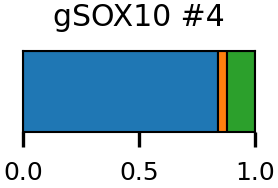

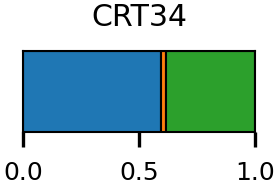

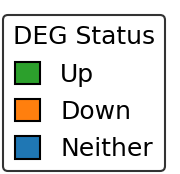

In [47]:
# Now only for EMT cause I don't need the pie chart for the most part

t = {'gSOX10 #4':'grna', 'CRT34':'crt'}
# Creating a single dataframe that will then be used to create a stacked bar chart 
for comp in ['gSOX10 #4', 'CRT34']:
    up_genes = comp_genes[comp]
    up_gene_names = data[data['ensembl_gene_id'].isin(up_genes)]['external_gene_name'].tolist()
    dn_genes = comp_down_genes[comp]
    dn_gene_names = data[data['ensembl_gene_id'].isin(dn_genes)]['external_gene_name'].tolist()
    temp_df = pd.DataFrame(columns=['Value'])
    for hall in ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']:
        gene = hall_gs[hall]
        
        temp_df.loc['Up'] = len(set(gene).intersection(up_gene_names))/len(gene)
        temp_df.loc['Down'] = len(set(gene).intersection(dn_gene_names))/len(gene)
        temp_df.loc['Neither'] = len(set(gene).difference(up_gene_names+dn_gene_names))/len(gene)
    print(f"For {comp} there are {len(set(gene).intersection(up_gene_names))} up-DEGs that overlap with EMT which makes up {temp_df.loc['Up']['Value']}")
    if comp == 'CRT34':
        temp_df[::-1].T.plot.barh(stacked=True, legend=True, edgecolor= 'k', linewidth =0.5)
        handles,labels = plt.gca().get_legend_handles_labels()
        plt.gca().get_legend().remove()
        
    else:
        temp_df[::-1].T.plot.barh(stacked=True, legend=False, edgecolor= 'k', linewidth =0.5)
    plt.gcf().set_size_inches(1,0.35)
    plt.tick_params('y', labelleft=False, left=False)
    plt.ylim(0,0.25)
    plt.margins(0,0)
    plt.title(comp)
    
    #plt.savefig(f'Figures/Manuscript Figures/Figure deDANSY/'+t[comp]+'_EMT_DEG_overlap.svg')
    if comp == 'CRT34':
        plt.figure(figsize=(0.5,0.5))
        plt.axis('off')
        l = plt.legend(handles, labels, handlelength=1, handleheight=1, title='DEG Status', reverse=True,)
        l.get_frame().set_linewidth(0.5)
        #plt.savefig('Figures/Manuscript Figures/Figure deDANSY/deg_overlap_legend.svg')


    


In [48]:
emt_prots = hall_conv['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION']

# Getting the overlap of EMT genes between both the conditions
emt_overlap_res = {}
for comp in ['4-11_v_A375','CRT34_v_A375']:
    deg_dansy.calc_DEG_ngrams(data_cols=['log2FoldChange_'+comp,'padj_'+comp],alpha=0.001,fc_thres=2,batch_mode=True)
    emt_specific_enrichment = ngramNets.ngram_subset_enrichment(emt_prots,deg_dansy.up_DEGs,  deg_dansy)
    emt_specific_enrichment = pd.DataFrame.from_dict(emt_specific_enrichment, orient='index')
    emt_specific_enrichment['ngram_name'] = [deg_dansy.return_legible_ngram(x) for x in emt_specific_enrichment.index]


    # Now cleaning the results to make them produce plots that are not redundant.
    clean_res = emt_specific_enrichment.copy()
    clean_res.rename({0:'p'}, axis=1, inplace=True)
    clean_res['-log10(p)'] = -np.log10(clean_res['p'])
    clean_res.index = clean_res['ngram_name']

    # In some instances will have to clean up the ngrams to maximize information because of repeats
    sorted_ngrams = sorted(clean_res['ngram_name'], key = lambda x: len(x.split('|')))
    if len(sorted_ngrams) > 20:
        skip_ngram = set()
        for n in sorted_ngrams:
            n_len = len(n.split('|'))
            n_unique = len(set(n.split('|')))
            n_p = clean_res.loc[n, 'p']
            ngram_check = set(sorted_ngrams).difference(skip_ngram)
            #if n_len > 2 and n_unique != 1:
            for m in ngram_check:
                if n != m and n in m:
                    m_len = len(m.split('|'))
                    m_p = clean_res.loc[m, 'p']
                    if n_p <= m_p:
                        skip_ngram.add(m)
    
    ngram_to_plot = list(set(sorted_ngrams).difference(skip_ngram))

    # Exporting the full results to a dict for plotting
    emt_overlap_res[comp] = {'ngram_plot':ngram_to_plot,
                             'cleaned':clean_res,
                             'base_enrichment':emt_specific_enrichment,
                             'emt_DEGs':list(set(emt_prots).intersection(deg_dansy.up_DEGs))}

<Figure size 900x900 with 0 Axes>

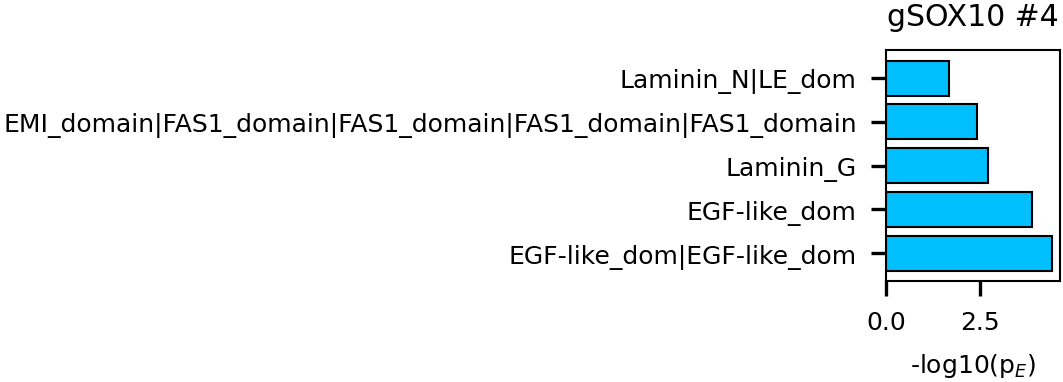

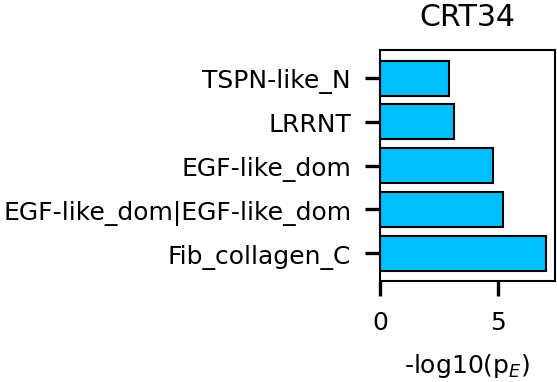

In [49]:
plt.figure(figsize=(3,3))
for i,comp in enumerate(emt_overlap_res, start=1):
    c = emt_overlap_res[comp]['cleaned']
    n_plot = emt_overlap_res[comp]['ngram_plot']
    c_filt = c[(c['p'] <= 0.05) & (c['ngram_name'].isin(n_plot))].copy()

    # Sorting the dataframe so that the top enriched n-grams are at the top
    c_filt.sort_values(by =['-log10(p)'], axis=0, ascending=False, inplace=True)
    max_rows = min([5,len(c_filt)])
    c_filt = c_filt.iloc[0:max_rows,]
    plt.figure(figsize=(0.75,1))
    plt.barh(width = c_filt['-log10(p)'], y = c_filt.index, edgecolor = 'k', linewidth =0.5, color ='deepskyblue')
    plt.title(plot_titles[comp]['Title'])
    plt.xlabel('-log10(p$_{E}$)')
    #plt.savefig('Figures/Manuscript Figures/Figure deDANSY/EMT_ngram_enrichment_'+comp+'.svg')

From those plots, we see there are clearly different functions enriched for each cell line that are being used for EMT. The CRT34 cells are using domains associated with collagen secretion, while the gSOX10 #4 cells are secreting laminin associated ECM to establish their phenotype. Thus, through deDANSy and n-gram enrichment we find the information that GSEA collapses with gene sets, but can represent distinctly different functions.

In [50]:
# Given the above plots showing the actual DEGs that correspond to the specific n-grams

# This is to print the genes associated with the gSOX10 n-grams
comp = '4-11_v_A375'
interpro_ids = ['IPR001791','IPR011489|IPR000782|IPR000782|IPR000782|IPR000782'] # Laminin and the FAS1 domains

full_unis_OI = set()
for id in interpro_ids:
    unis = deg_dansy.interpro2uniprot[id]
    emt_unis = emt_overlap_res[comp]['emt_DEGs']
    x = set(unis).intersection(emt_unis)
    full_unis_OI.update(x)

deg_dansy.retrieve_protein_info(prot = full_unis_OI)


,UniProt ID,Gene,Species,Uniprot Domains,Ref Sequence,PDB IDs,Uniprot Domain Architecture,Interpro Domains,Interpro Domain Architecture,Interpro Domain Architecture IDs
2963,Q15582,TGFBI,Homo sapiens,EMI:45:99;FAS1 1:103:236;FAS1 2:240:371;FAS1 3...,MALFVRLLALALALALGPAATLAGPAKSPYQLVLQHSRLRGRQHGP...,1X3B;2LTB;2LTC;2VXP;5NV6;7AS7;7ASC;7ASG,EMI|FAS1 1|FAS1 2|FAS1 3|FAS1 4,EMI_domain:IPR011489:45:99;FAS1_domain:IPR0007...,EMI_domain|FAS1_domain|FAS1_domain|FAS1_domain...,IPR011489|IPR000782|IPR000782|IPR000782|IPR000782
3122,P24043,LAMA2,Homo sapiens,Laminin N-terminal:35:286;Laminin EGF-like 1:2...,MPGAAGVLLLLLLSGGLGGVQAQRPQQQRQSQAHQQRGLFPAVLNL...,4YEP;4YEQ,Laminin N-terminal|Laminin EGF-like 1|Laminin ...,Laminin_N:IPR008211:33:286;LE_dom:IPR002049:28...,Laminin_N|LE_dom|LE_dom|EGF-like_dom|EGF-like_...,IPR008211|IPR002049|IPR002049|IPR000742|IPR000...
5134,P20908,COL5A1,Homo sapiens,Laminin G-like:72:244;Fibrillar collagen NC1:1...,MDVHTRWKARSALRPGAPLLPPLLLLLLWAPPPSRAAQPADLLKVL...,,Laminin G-like|Fibrillar collagen NC1,Laminin_G:IPR001791:98:229;Fib_collagen_C:IPR0...,Laminin_G|Fib_collagen_C,IPR001791|IPR000885
12456,P25391,LAMA1,Homo sapiens,Laminin N-terminal:18:269;Laminin EGF-like 1:2...,MRGGVLLVLLLCVAAQCRQRGLFPAILNLASNAHISTNATCGEKGP...,,Laminin N-terminal|Laminin EGF-like 1|Laminin ...,Laminin_N:IPR008211:16:269;LE_dom:IPR002049:27...,Laminin_N|LE_dom|EGF-like_dom|EGF-like_dom|EGF...,IPR008211|IPR002049|IPR000742|IPR000742|IPR000...
19167,Q15063,POSTN,Homo sapiens,EMI:40:94;FAS1 1:97:230;FAS1 2:234:365;FAS1 3:...,MIPFLPMFSLLLLLIVNPINANNHYDKILAHSRIRGRDQGPNVCAL...,5WT7;5YJG;5YJH,EMI|FAS1 1|FAS1 2|FAS1 3|FAS1 4,EMI_domain:IPR011489:40:94;FAS1_domain:IPR0007...,EMI_domain|FAS1_domain|FAS1_domain|FAS1_domain...,IPR011489|IPR000782|IPR000782|IPR000782|IPR000782


In [51]:
comp = 'CRT34_v_A375'
interpro_ids = ['IPR000885','IPR048287'] # Collagen and TSPN domains
full_unis_OI = set()
for id in interpro_ids:
    unis = deg_dansy.interpro2uniprot[id]
    emt_unis = emt_overlap_res[comp]['emt_DEGs']
    x = set(unis).intersection(emt_unis)
    full_unis_OI.update(x)

deg_dansy.retrieve_protein_info(prot = full_unis_OI)

,UniProt ID,Gene,Species,Uniprot Domains,Ref Sequence,PDB IDs,Uniprot Domain Architecture,Interpro Domains,Interpro Domain Architecture,Interpro Domain Architecture IDs
1117,P25940,COL5A3,Homo sapiens,Laminin G-like:62:224;Collagen-like 1:391:440;...,MGNRRDLGQPRAGLCLLLAALQLLPGTQADPVDVLKALGVQGGQAG...,,Laminin G-like|Collagen-like 1|Collagen-like 2...,TSPN-like_N:IPR048287:31:210;Fib_collagen_C:IP...,TSPN-like_N|Fib_collagen_C,IPR048287|IPR000885
2609,Q99715,COL12A1,Homo sapiens,Fibronectin type-III 1:27:117;VWFA 1:140:316;F...,MRSRLPPALAALGAALLLSSIEAEVDPPSDLNFKIIDENTVHMSWA...,,Fibronectin type-III 1|VWFA 1|Fibronectin type...,FN3_dom:IPR003961:25:117;VWF_A:IPR002035:138:3...,FN3_dom|VWF_A|FN3_dom|VWF_A|FN3_dom|FN3_dom|FN...,IPR003961|IPR002035|IPR003961|IPR002035|IPR003...
5134,P20908,COL5A1,Homo sapiens,Laminin G-like:72:244;Fibrillar collagen NC1:1...,MDVHTRWKARSALRPGAPLLPPLLLLLLWAPPPSRAAQPADLLKVL...,,Laminin G-like|Fibrillar collagen NC1,Laminin_G:IPR001791:98:229;Fib_collagen_C:IPR0...,Laminin_G|Fib_collagen_C,IPR001791|IPR000885
5827,P08123,COL1A2,Homo sapiens,Fibrillar collagen NC1:1133:1366,MLSFVDTRTLLLLAVTLCLATCQSLQEETVRKGPAGDRGPRGERGP...,5CTD;5CTI;5CVA;6JEC,Fibrillar collagen NC1,Fib_collagen_C:IPR000885:1132:1366,Fib_collagen_C,IPR000885
8711,P02452,COL1A1,Homo sapiens,VWFC:38:96;Fibrillar collagen NC1:1229:1464,MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...,1Q7D;2LLP;3EJH;3GXE;5CTD;5CTI;5CVA;5CVB;5K31;5...,VWFC|Fibrillar collagen NC1,VWF_dom:IPR001007:38:96;Fib_collagen_C:IPR0008...,VWF_dom|Fib_collagen_C,IPR001007|IPR000885
10642,P35442,THBS2,Homo sapiens,Laminin G-like:19:215;VWFC:318:375;TSP type-1 ...,MVWRLVLLALWVWPSTQAGHQDKDTTFDLFSISNINRKTIGAKQFR...,1YO8;2RHP,Laminin G-like|VWFC|TSP type-1 1|TSP type-1 2|...,TSPN-like_N:IPR048287:20:215;VWF_dom:IPR001007...,TSPN-like_N|VWF_dom|EGF-like_dom|EGF-like_dom|...,IPR048287|IPR001007|IPR000742|IPR000742|IPR000...
10663,Q07092,COL16A1,Homo sapiens,Laminin G-like:50:231;Collagen-like 1:375:423;...,MWVSWAPGLWLLGLWATFGHGANTGAQCPPSQQEGLKLEHSSSLPA...,,Laminin G-like|Collagen-like 1|Collagen-like 2...,TSPN-like_N:IPR048287:50:231,TSPN-like_N,IPR048287
11238,P02461,COL3A1,Homo sapiens,VWFC:30:89;Fibrillar collagen NC1:1232:1466,MMSFVQKGSWLLLALLHPTIILAQQEAVEGGCSHLGQSYADRDVWK...,2V53;3DMW;4AE2;4AEJ;4AK3;4GYX;6FZV;6FZW;7WWR;7...,VWFC|Fibrillar collagen NC1,VWF_dom:IPR001007:30:89;Fib_collagen_C:IPR0008...,VWF_dom|Fib_collagen_C,IPR001007|IPR000885
11567,P05997,COL5A2,Homo sapiens,VWFC:39:97;Fibrillar collagen NC1:1266:1499,MMANWAEARPLLILIVLLGQFVSIKAQEEDEDEGYGEEIACTQNGQ...,,VWFC|Fibrillar collagen NC1,VWF_dom:IPR001007:39:97;Fib_collagen_C:IPR0008...,VWF_dom|Fib_collagen_C,IPR001007|IPR000885
